In [1]:
# -*- coding: utf-8 -*-
#  File: otus_adv_hw1_automl_atom.ipynb
#  Project: 'OTUS.ADV Homework #1'
#  Created by Gennady Matveev (gm@og.ly) on 06-01-2022.

# **$Homework$** **$3$**  
**OTUS Machine Learning Advanced**

### Time series clustering

![AutoML](https://docs.google.com/uc?export=download&id=1kP52pViswEsaHNrJUuCUxwXng4oBY3Cu)
<!-- https://drive.google.com/file/d/1kP52pViswEsaHNrJUuCUxwXng4oBY3Cu/view?usp=sharing -->

Apply clustering algorithms to multiple time series (TS):
- A list of cryptocurrencies (CC), including Bitcoin (~100)
    - 30 days of closing prices
    - 3 days hourly closing prices
    - 1 hour minute closing prices
- Compare KNN (or similar) and DTW approaches;
- Try TS clustering after feature generation with TSFEL;
- Analyze composition of clusters without Bitcoin.

**Additional goals:**  

- Build risk profile for CC portfolios from one cluster and from
different clusters;
- Apply Matrix Profile methods from [matrixprofile](https://github.com/matrix-profile-foundation/matrixprofile) library to find repeated motifs and discords (anomalies) on CC from various clusters.


**Means:**  

- All meaningful computations will be done in [tslearn](https://github.com/tslearn-team/tslearn/).  

**Data:**  

- CC prices will be downloaded with [cryptocompare](https://github.com/lagerfeuer/cryptocompare) library.

**Choice of models:**  



**Methodology:**  


Goals:   

Apply clustering algorithms to multiple time series (TS):
- A list of cryptocurrencies (CC), including Bitcoin (~100)
    - 30 days of closing prices
    - 3 days hourly closing prices
    - 1 hour minute closing prices
- Compare KNN (or similar) and DTW approaches;
- Analyze composition of clusters without Bitcoin.

Means:  
- All preprocessing and pipelines management will be done in [ATOM](https://tvdboom.github.io/ATOM/).

Data:
- CC prices will be downloaded with [cryptocompare](https://github.com/lagerfeuer/cryptocompare) library.

Abbreviations:
- TS: time series
- CC: cryptocurrency
- DTW: dynamic time warping
- H/P: hyperparameters

<a href="https://colab.research.google.com/github/oort77/OTUS_ADV_HW3/blob/main/notebooks/otus_adv_hw3_dtw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Google colab specific part

In [2]:
# !pip install -r 'https://drive.google.com/uc?export=download&id=1VmHDlGXo1IMHZ2kAT5IW4r4suWAfmiXs'

### Import libraries and setup notebook

In [3]:
# %load_ext nb_black
import os
import sys
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
import tsfel

import cryptocompare as cc

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly
from umap import UMAP

import re
import gdown
import random
import shutil
import pickle
import warnings
import requests
from kneed import KneeLocator
from tqdm.autonotebook import tqdm
from IPython.core.display import display, HTML


/home/gm/anaconda3/envs/atom/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


#### Import utilities functions

In [4]:
if os.path.abspath("..") not in sys.path:
    sys.path.insert(0, os.path.abspath(".."))
from src.utilities import *

#### Miscellaneius settings 

In [5]:
%matplotlib inline
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (10, 5)
sns.set(rc={"figure.figsize": (8, 5)})
warnings.filterwarnings("ignore")
pd.options.display.precision = 4

#### ML parameters

In [6]:
random_state = 17
n_jobs = -1 
scaler = StandardScaler()

### Load data

#### Set up cryptocompare API

In [7]:
cc.cryptocompare._set_api_key_parameter(
    "5db769e8ae211fc8c106e10623db6384dc64db9c26b2a2df708f8d1b53f99f92"
)

'&api_key=5db769e8ae211fc8c106e10623db6384dc64db9c26b2a2df708f8d1b53f99f92'

#### Download data, top-100 CC by market cap

In [8]:
if os.path.isdir("../data") == False:
    !mkdir ../data

url_arch = (
    "https://drive.google.com/uc?export=download&id=1XCOhxPfRDp6SxMyPwPO1nse3MI2vOFvP"
)
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36"
}

# Download, if necessary
if not os.path.exists("../data/Archive.zip"):
    # Check if data archive is still in Google Drive
    if requests.head(url_arch, headers=headers).status_code in [200, 302]:
        gdown.download(url_arch, output="../data/Archive.zip")
        shutil.unpack_archive("../data/Archive.zip", "../data")
    # If not, get data from cryptocompare.com
    else:
        data_day = get_all_cc("day", 30)
        data_hour = get_all_cc("hour", 72)
        data_minute = get_all_cc("minute", 60)
# Extract data from existing pickles
else:
    with open("../data/data_day.pickle", "rb") as f:
        data_day = pickle.load(f)
    with open("../data/data_hour.pickle", "rb") as f:
        data_hour = pickle.load(f)
    with open("../data/data_minute.pickle", "rb") as f:
        data_minute = pickle.load(f)

In [9]:
# Check CC list dataframe
if not os.path.exists("../data/cryptocurrencies.pickle"):
    cc_url = "https://drive.google.com/uc?export=download&id=1Q09m-PfvhiBZ75lwXaHtafsajmXPW3WD"
    gdown.download(cc_url, output="../data/cryptocurrencies.pickle")
with open("../data/cryptocurrencies.pickle", "rb") as f:
    ccs = pickle.load(f)
tickers = ccs["ticker"].to_list()

#### Save data to pickles

In [10]:
# with open("../data/data_minute.pickle","wb") as f:
#             pickle.dump(data_minute, f)
# with open("../data/data_hour.pickle","wb") as f:
#             pickle.dump(data_hour, f)
# with open("../data/data_day.pickle","wb") as f:
#             pickle.dump(data_day, f)

### CC data - visual check

In [11]:
data_day.head()

BTC      ETH     XRP   USDT     BNB     SOL    USDC   LUNA    ADA  \
0  42743.03  3240.32  0.7703  1.001  463.38  140.25  1.0000  73.51  1.188   
1  43919.67  3373.03  0.7989  1.000  487.51  151.51  1.0000  81.91  1.312   
2  42575.61  3242.26  0.7678  1.000  475.57  146.20  1.0000  78.36  1.233   
3  43089.83  3309.66  0.7734  1.001  490.36  146.18  1.0000  81.45  1.293   
4  43088.74  3328.63  0.7796  1.000  494.66  147.74  0.9996  87.30  1.292   

    AVAX  ...  FXS      HT     CHZ    ENJ   JASMY    ENS    XCH    DFI  \
0  89.64  ...  0.0   9.403  0.2641  2.317  0.0708  26.75  88.52  2.618   
1  96.02  ...  0.0   9.509  0.2775  2.521  0.0730  27.99  95.48  2.994   
2  89.76  ...  0.0   9.511  0.2637  2.374  0.0695  25.69  92.94  2.971   
3  90.40  ...  0.0   9.855  0.2668  2.411  0.0707  26.28  91.61  3.001   
4  93.08  ...  0.0  10.020  0.2669  2.452  0.0703  26.68  92.12  3.102   

      BSV    ANC  
0  110.19  2.592  
1  112.83  2.704  
2  109.33  2.600  
3  113.02  2.503  
4  112.63  2.506  

[5 rows x 95 columns]

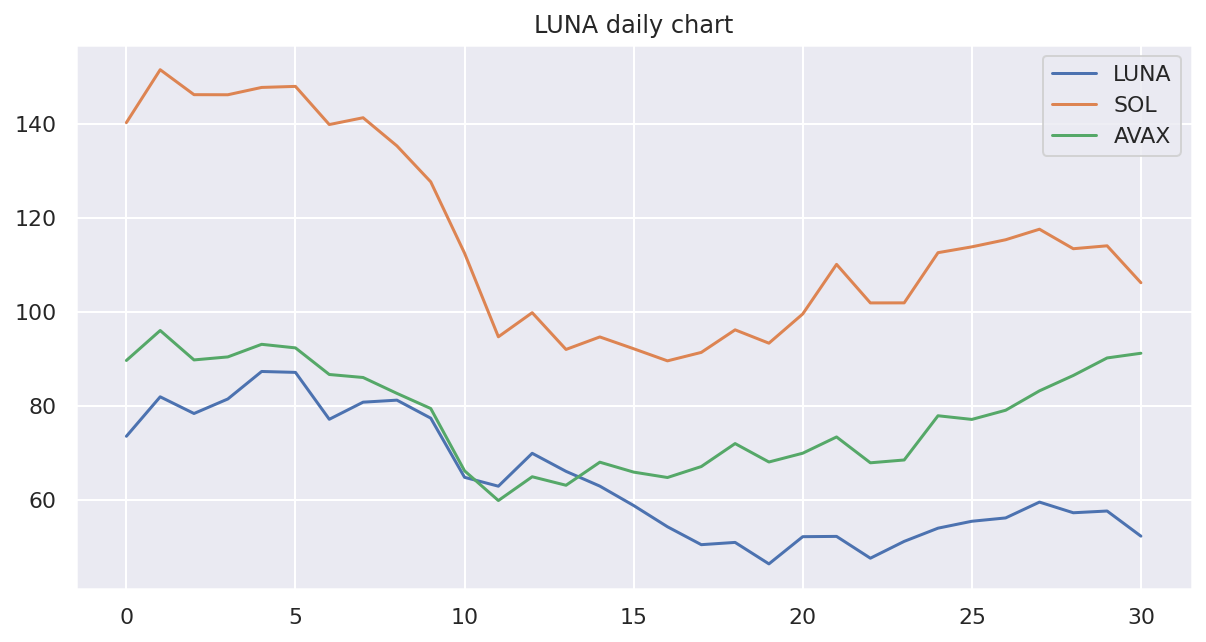

In [12]:
_ = data_day[["LUNA", "SOL", "AVAX"]].plot(title="LUNA daily chart", figsize=(10, 5))

In [13]:
data_hour.head()

BTC      ETH     XRP   USDT     BNB     SOL    USDC   LUNA    ADA  \
0  44093.55  3153.03  0.8012  1.001  435.07  117.99  1.0000  59.26  1.188   
1  44104.37  3154.29  0.8265  1.001  434.96  118.10  0.9999  60.39  1.204   
2  43861.07  3141.38  0.8318  1.001  433.75  117.57  1.0000  59.51  1.199   
3  43886.13  3132.57  0.8260  1.001  433.08  117.11  1.0000  58.84  1.237   
4  44081.16  3154.16  0.8684  1.001  435.15  118.78  1.0000  59.67  1.251   

    AVAX  ...    FXS     HT     CHZ    ENJ   JASMY    ENS    XCH    DFI  \
0  83.51  ...  21.16  10.11  0.2338  2.121  0.0418  21.56  79.99  3.308   
1  83.64  ...  21.51  10.16  0.2347  2.127  0.0417  21.92  80.23  3.326   
2  83.18  ...  21.16  10.09  0.2337  2.090  0.0411  21.81  80.49  3.338   
3  82.59  ...  21.24  10.02  0.2326  2.085  0.0412  21.81  80.05  3.357   
4  83.36  ...  21.47  10.02  0.2355  2.127  0.0416  22.75  80.62  3.411   

      BSV    ANC  
0  102.68  1.578  
1  103.03  1.592  
2  102.15  1.604  
3  103.04  1.603  
4  104.23  1.627  

[5 rows x 95 columns]

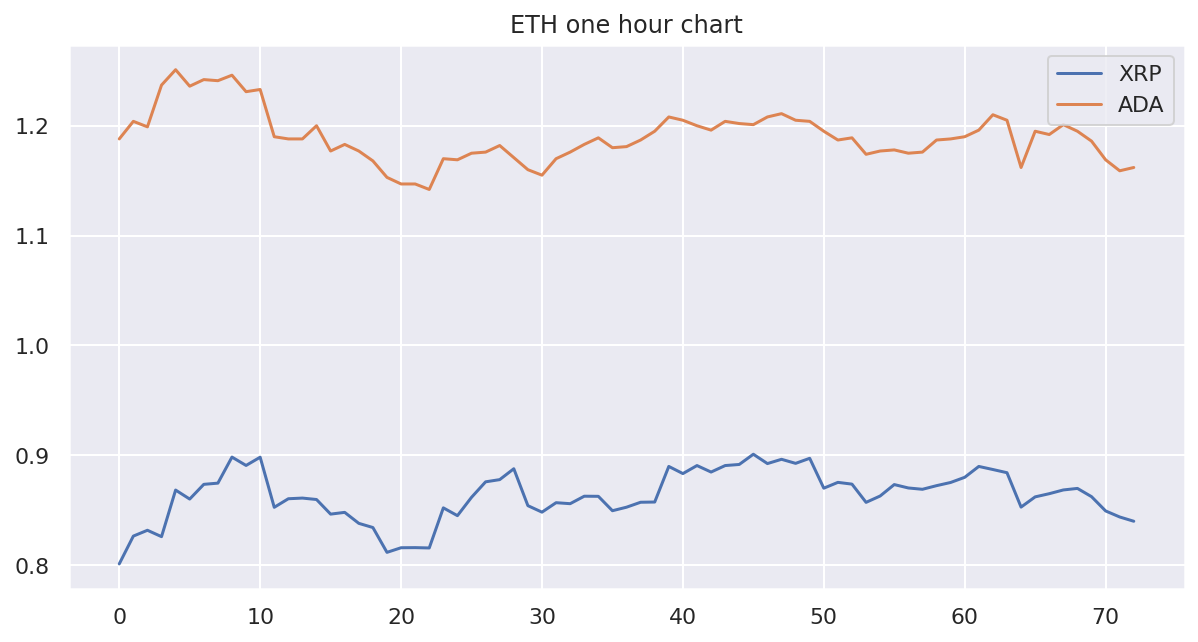

In [14]:
_ = data_hour[["XRP", "ADA"]].plot(title="ETH one hour chart", figsize=(10, 5))

In [15]:
data_minute.head()

BTC      ETH     XRP   USDT     BNB     SOL    USDC   LUNA    ADA  \
0  44571.95  3132.77  0.8549  1.001  422.01  109.21  1.0000  53.99  1.172   
1  44618.14  3136.05  0.8554  1.001  422.12  109.35  1.0000  54.03  1.173   
2  44580.50  3133.94  0.8546  1.001  421.80  109.16  0.9999  53.90  1.172   
3  44559.75  3135.46  0.8547  1.001  421.87  109.14  1.0000  53.78  1.171   
4  44568.13  3137.96  0.8540  1.001  421.83  109.28  1.0010  53.89  1.172   

    AVAX  ...    FXS     HT     CHZ    ENJ   JASMY    ENS    XCH    DFI  \
0  91.91  ...  21.08  10.02  0.2314  2.032  0.0401  19.35  82.77  3.671   
1  91.98  ...  21.10  10.03  0.2315  2.033  0.0401  19.37  82.86  3.675   
2  91.70  ...  20.96  10.01  0.2315  2.033  0.0399  19.34  82.61  3.672   
3  91.76  ...  21.08  10.00  0.2310  2.032  0.0401  19.34  82.66  3.670   
4  91.93  ...  20.95  10.03  0.2312  2.038  0.0399  19.31  82.67  3.665   

     BSV    ANC  
0  99.84  1.811  
1  99.94  1.814  
2  99.86  1.815  
3  99.72  1.812  
4  99.74  1.815  

[5 rows x 95 columns]

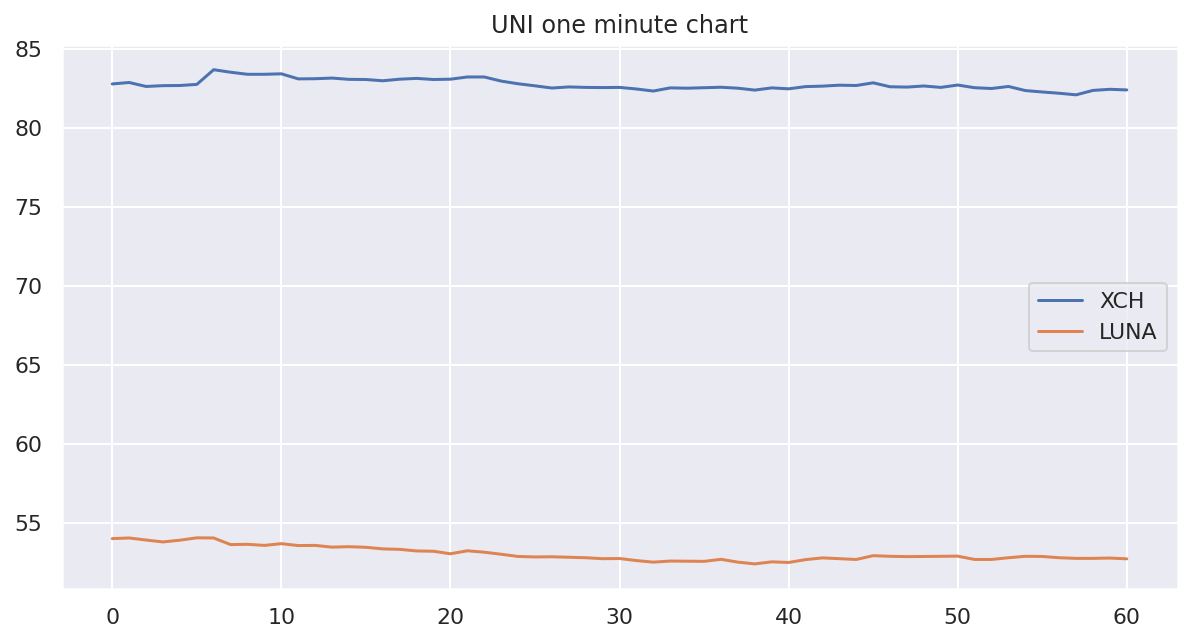

In [16]:
_ = data_minute[["XCH", "LUNA"]].plot(title="UNI one minute chart", figsize=(10, 5))

TODO: show clusters composition

### Run clustering study

#### Daily charts

##### KNeighbours, euclidean metric

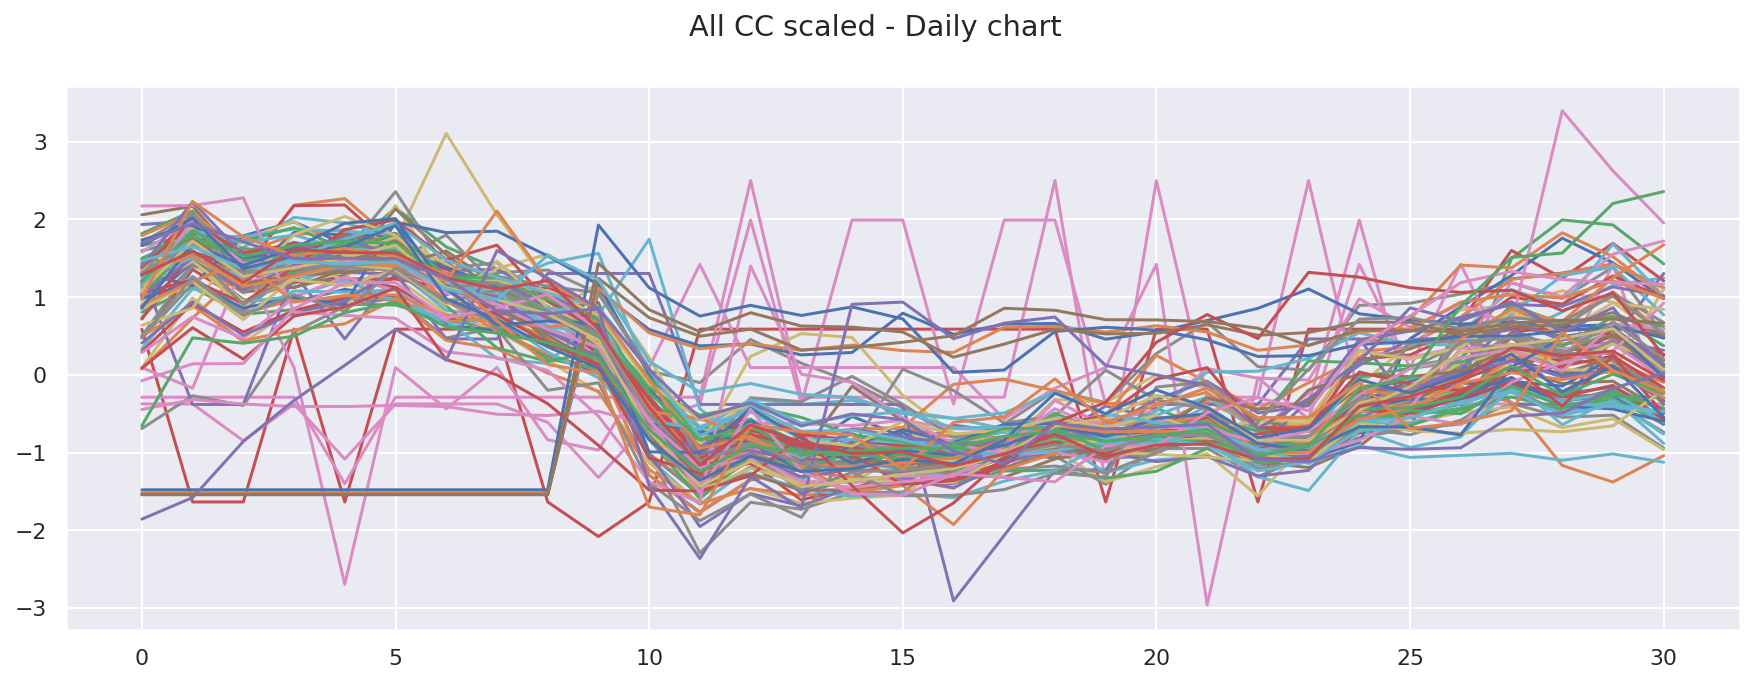

  0%|          | 0/8 [00:00<?, ?it/s]

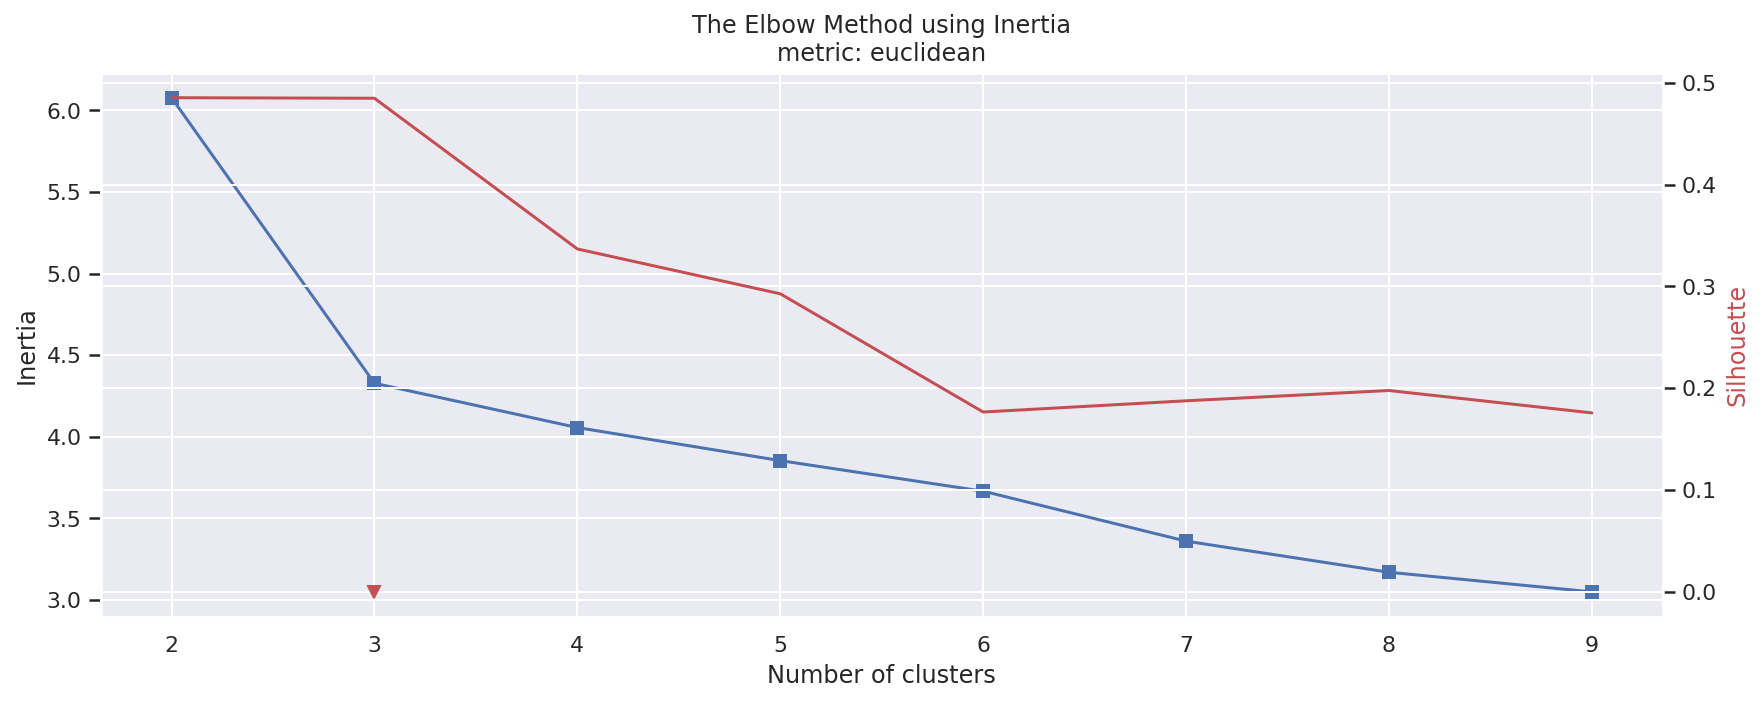

Optimal number of clusters: 3


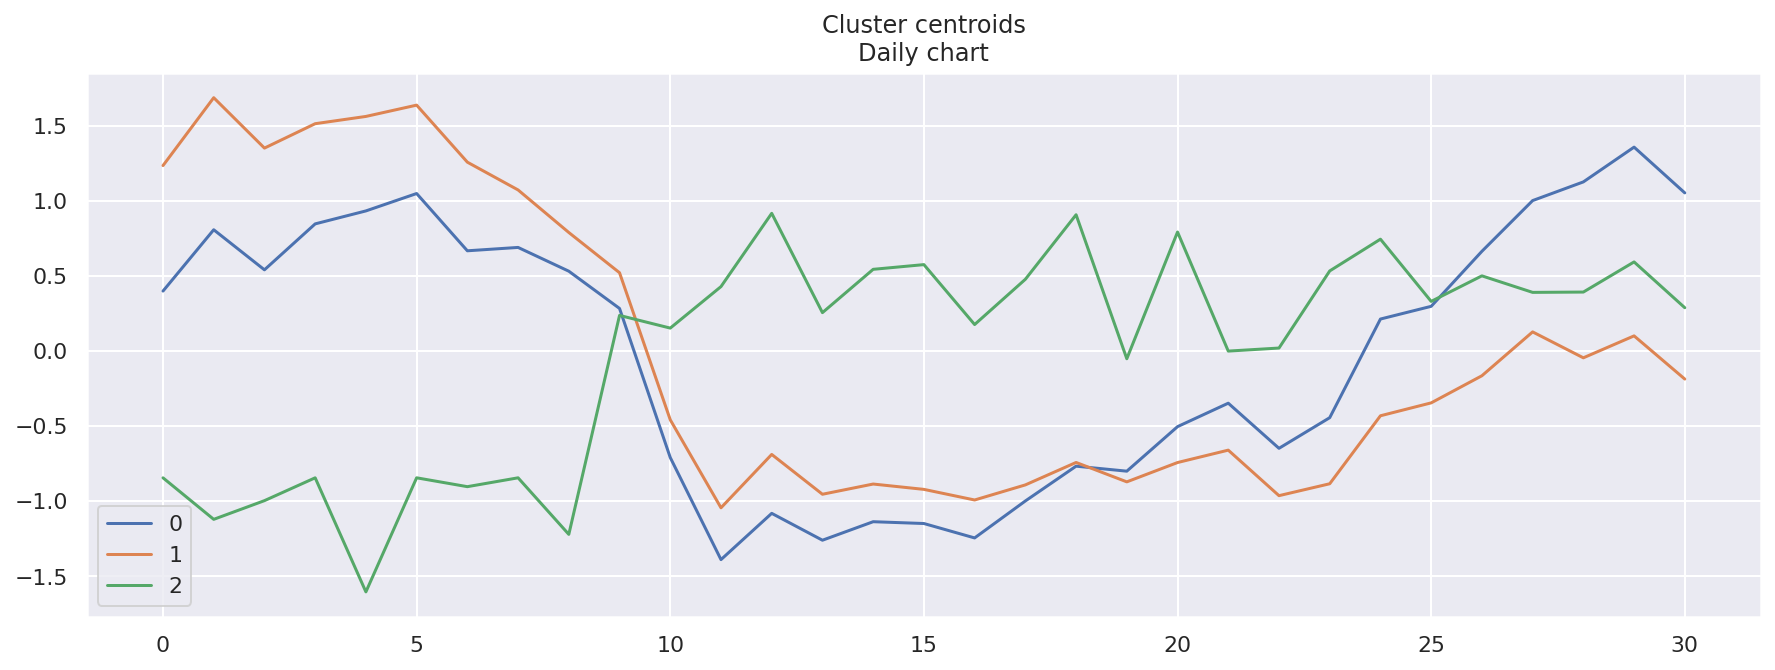

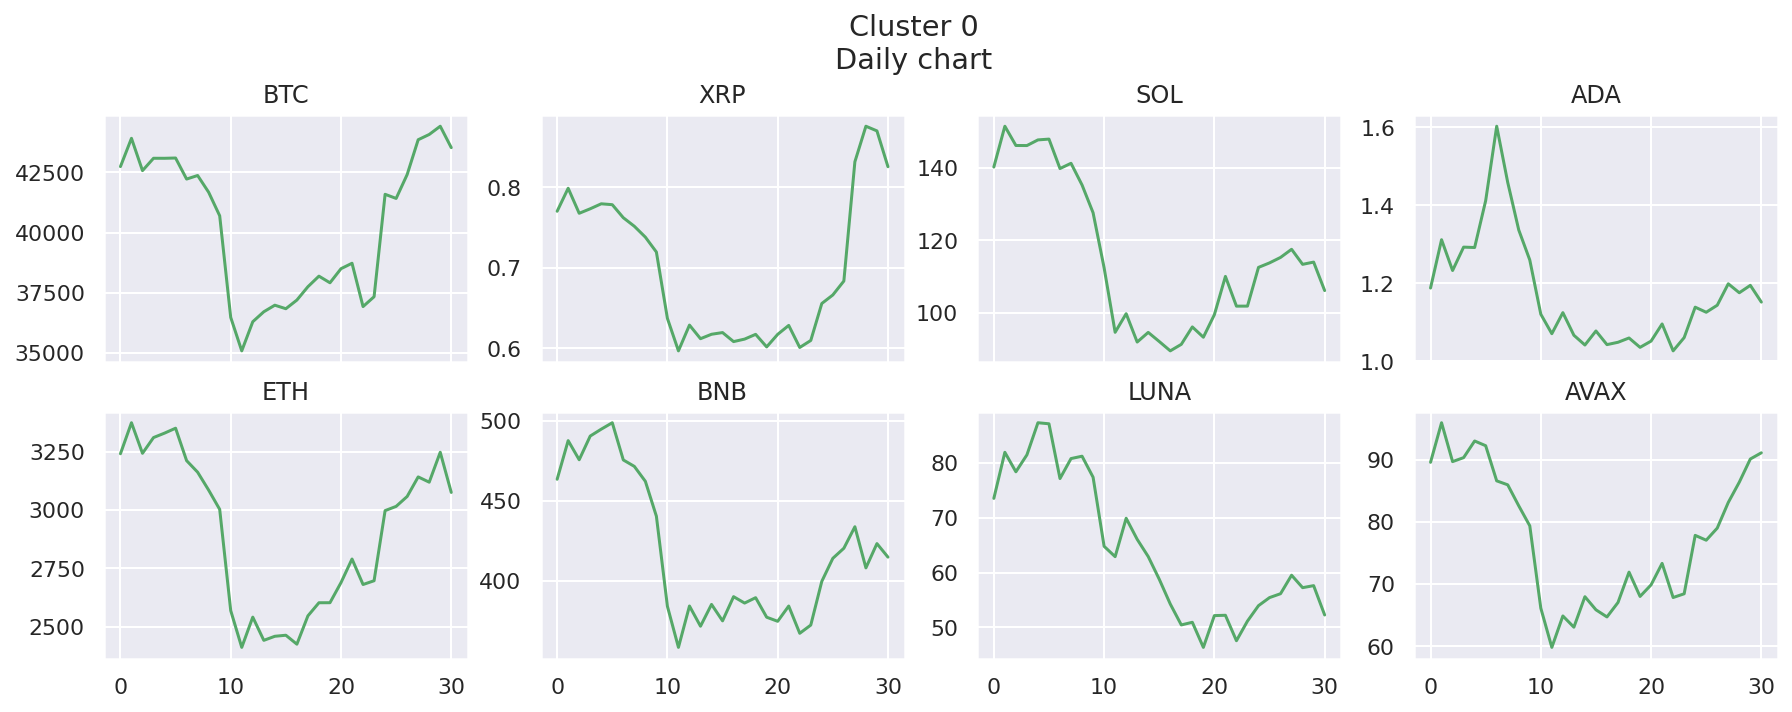

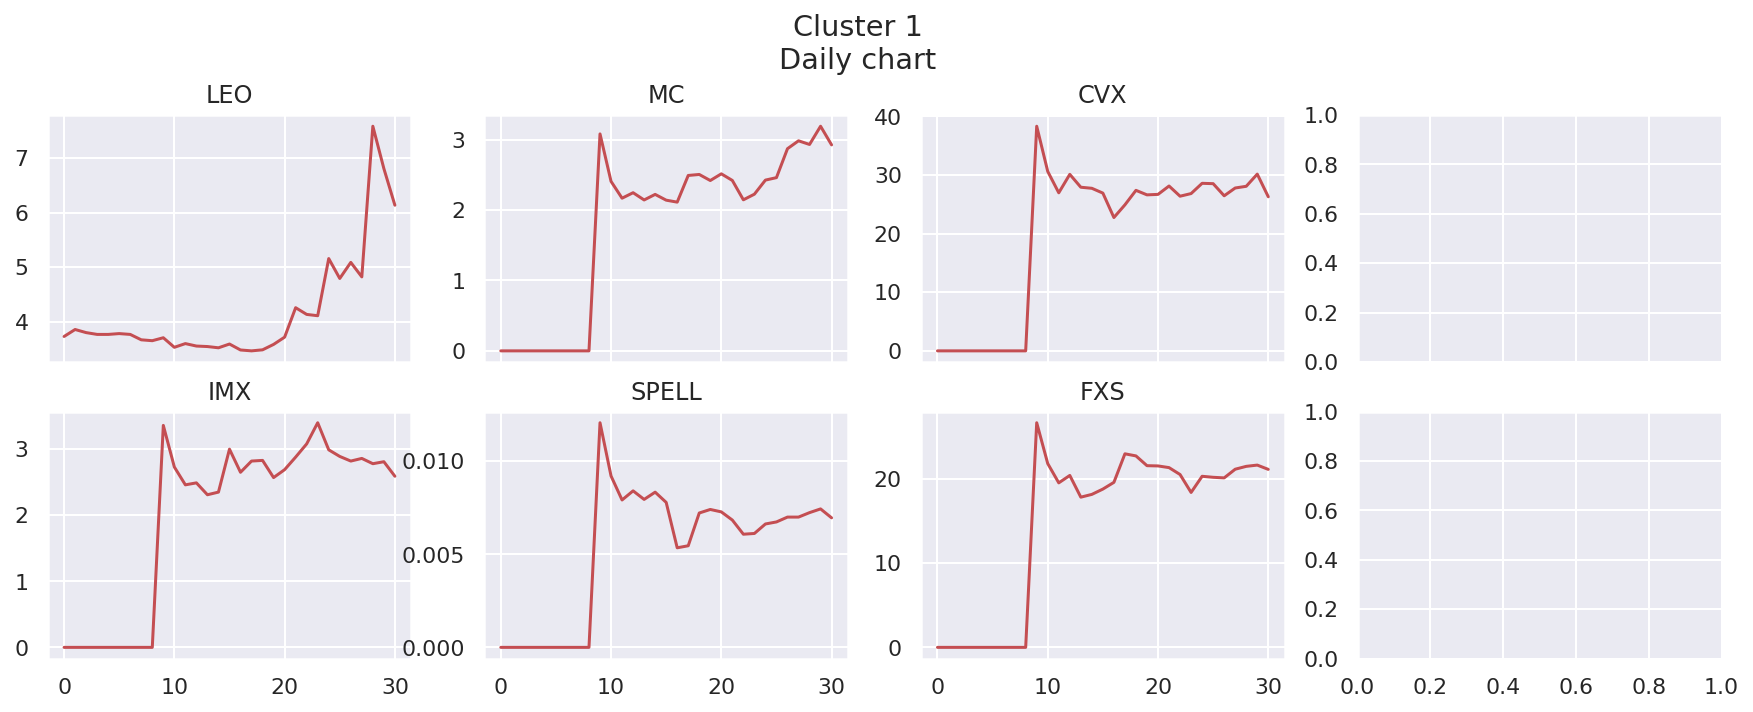

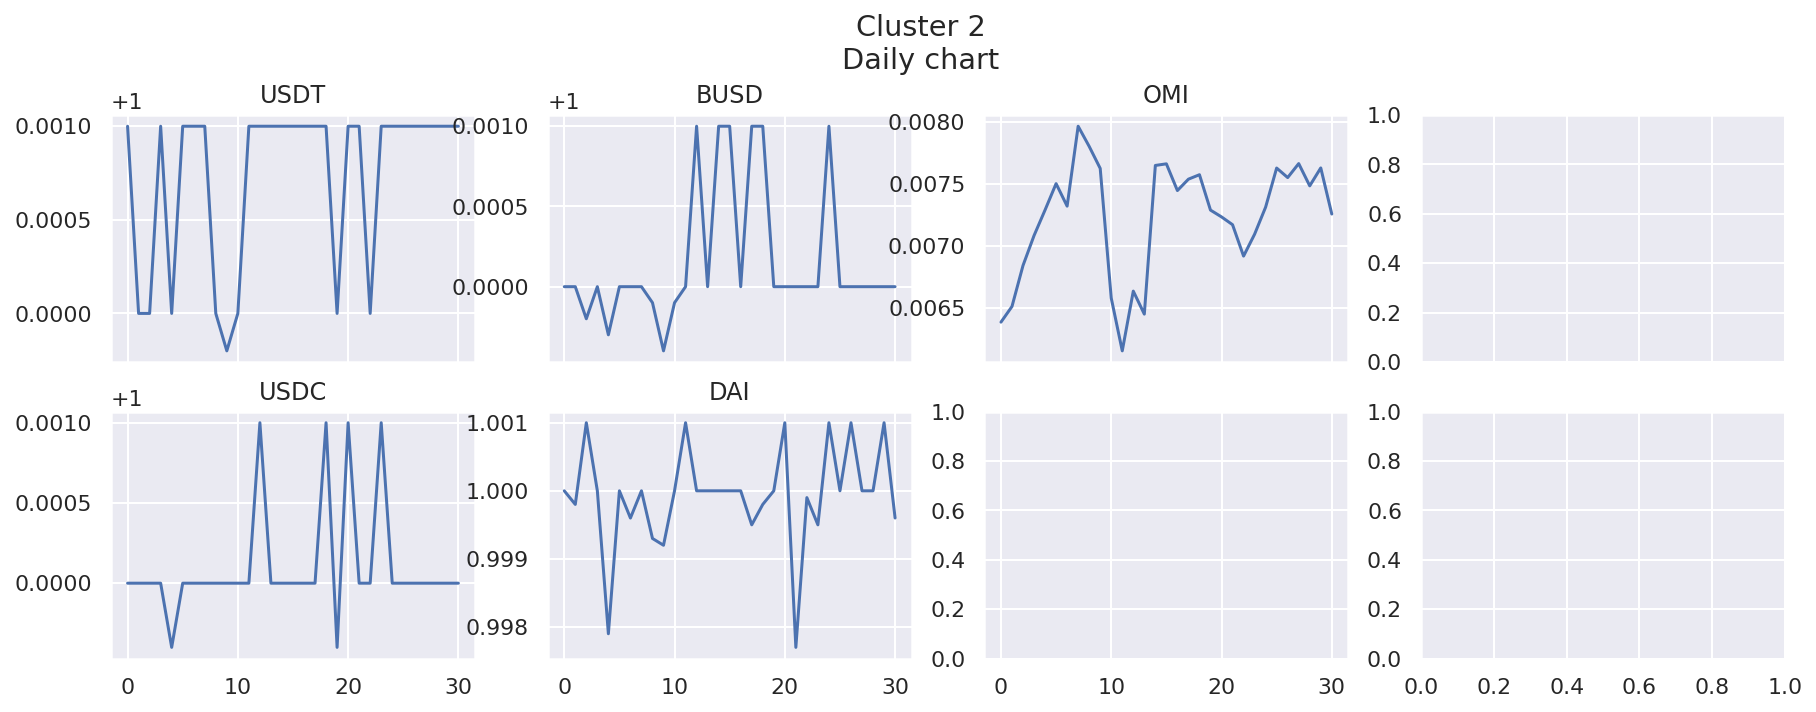

In [17]:
clustering_study(data_day, metric="euclidean", title="Daily chart")

##### KNeighbours, DTW

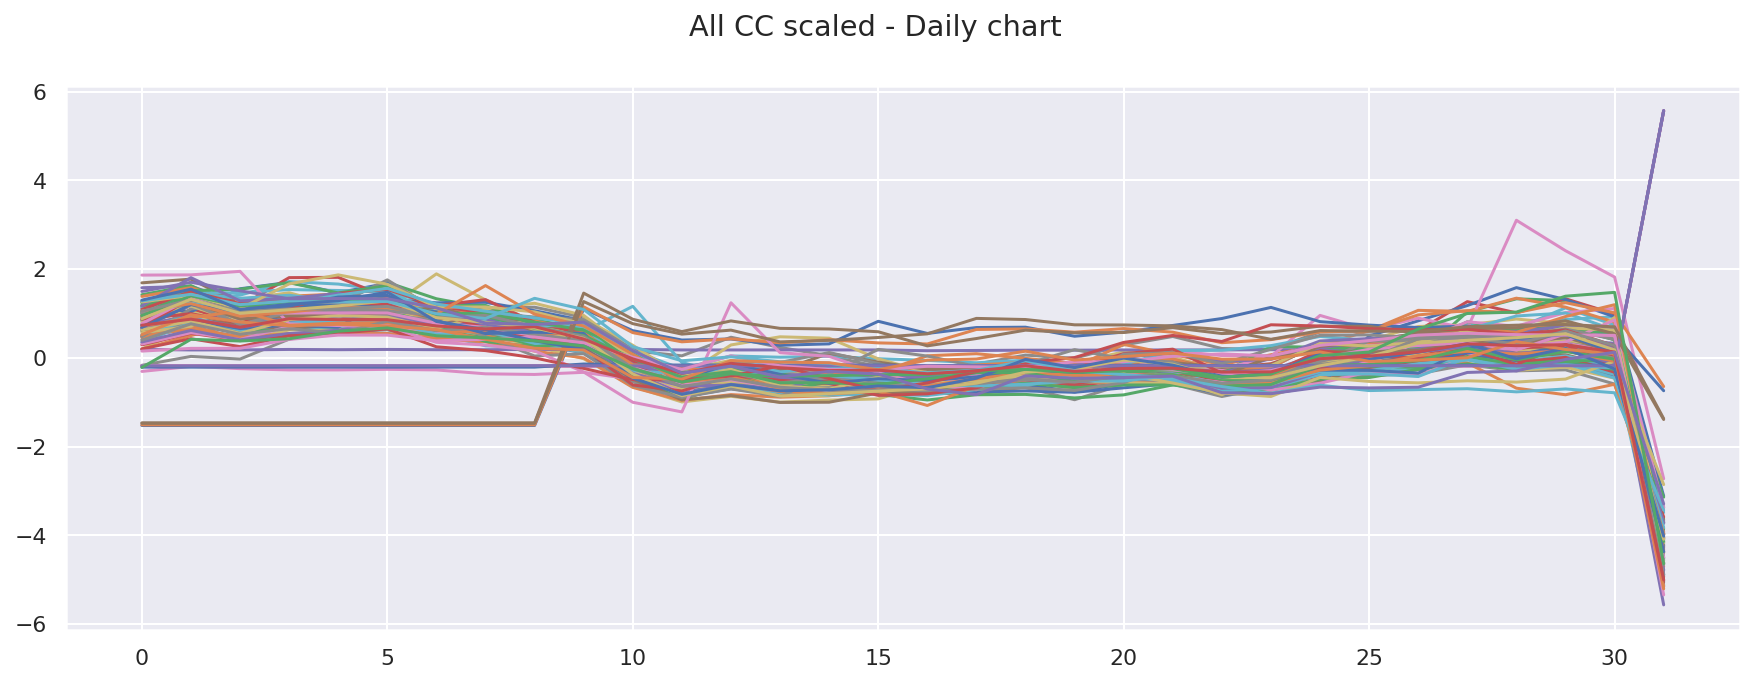

  0%|          | 0/8 [00:00<?, ?it/s]

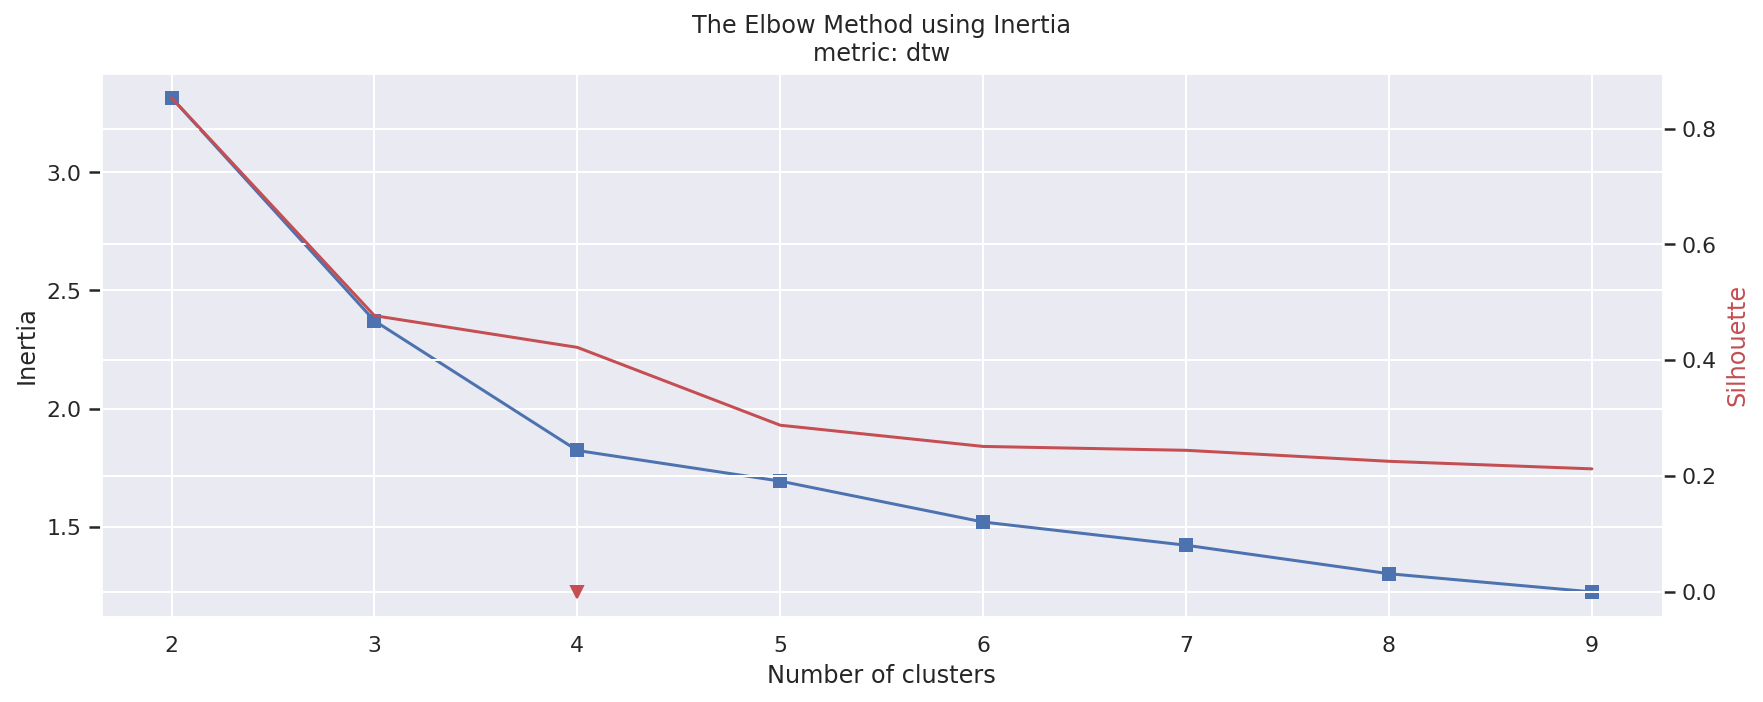

Optimal number of clusters: 4


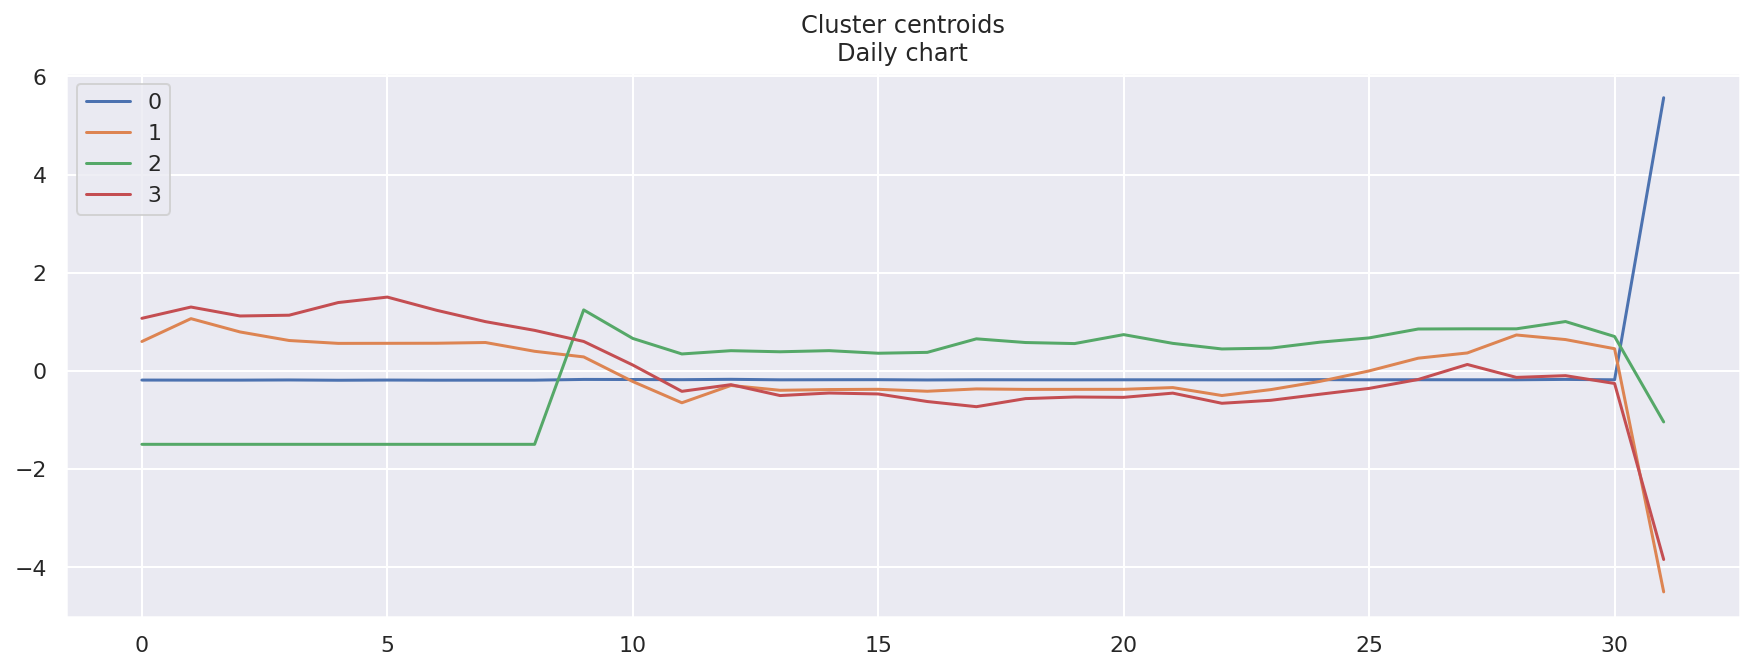

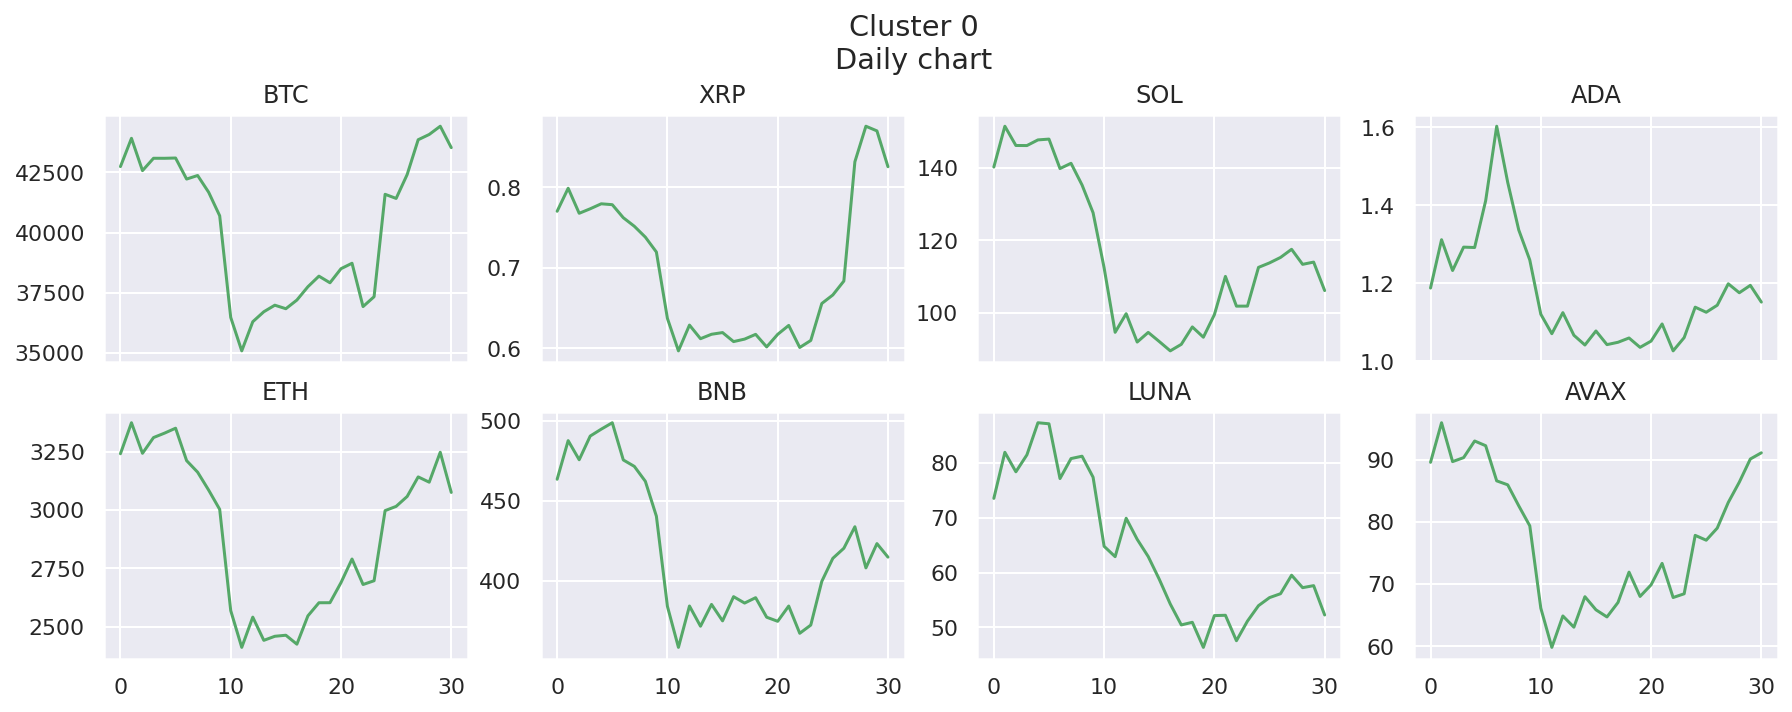

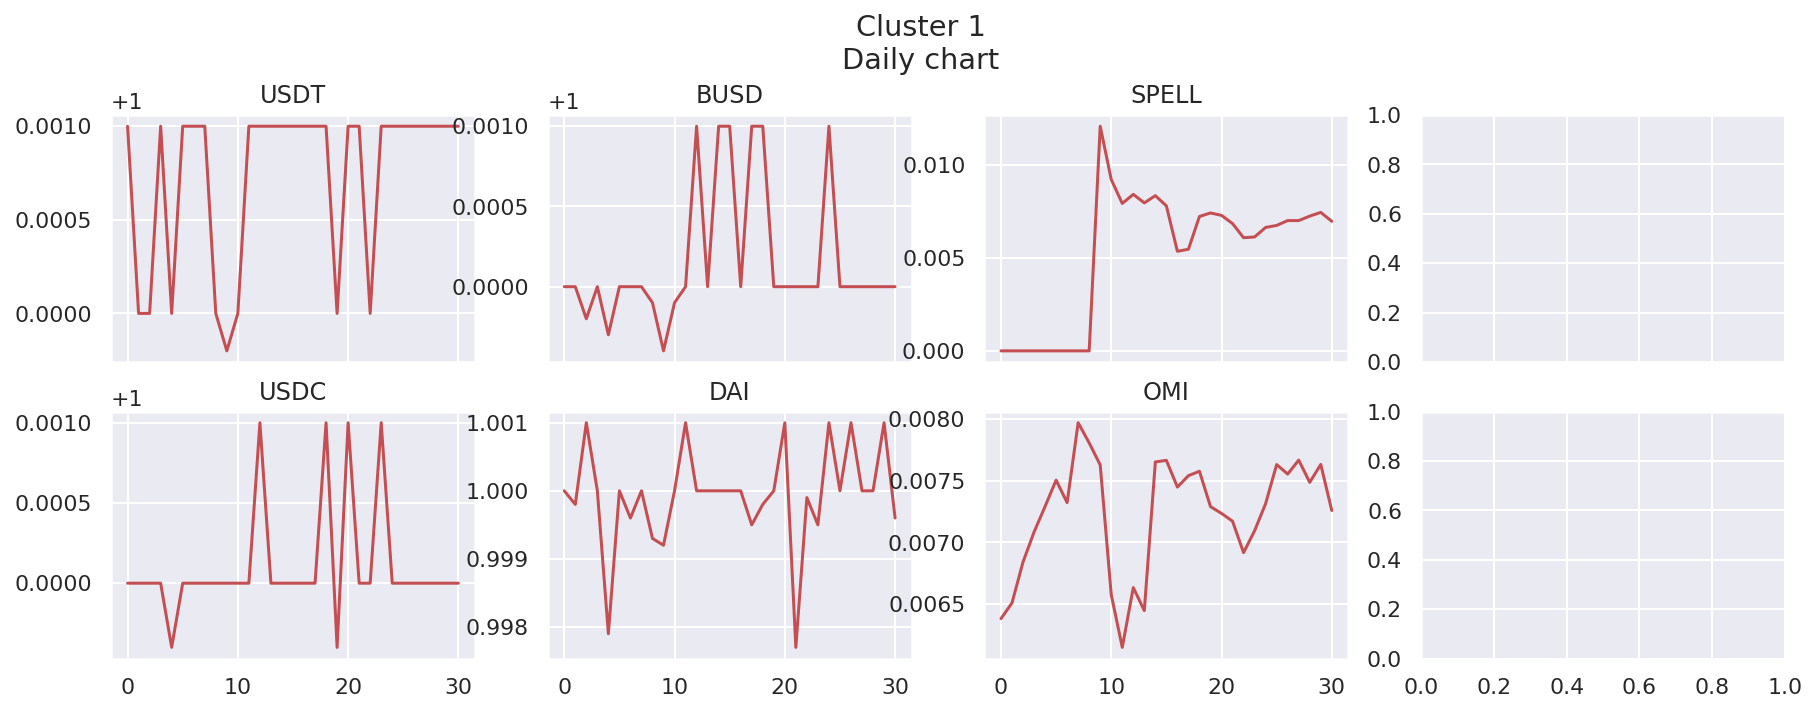

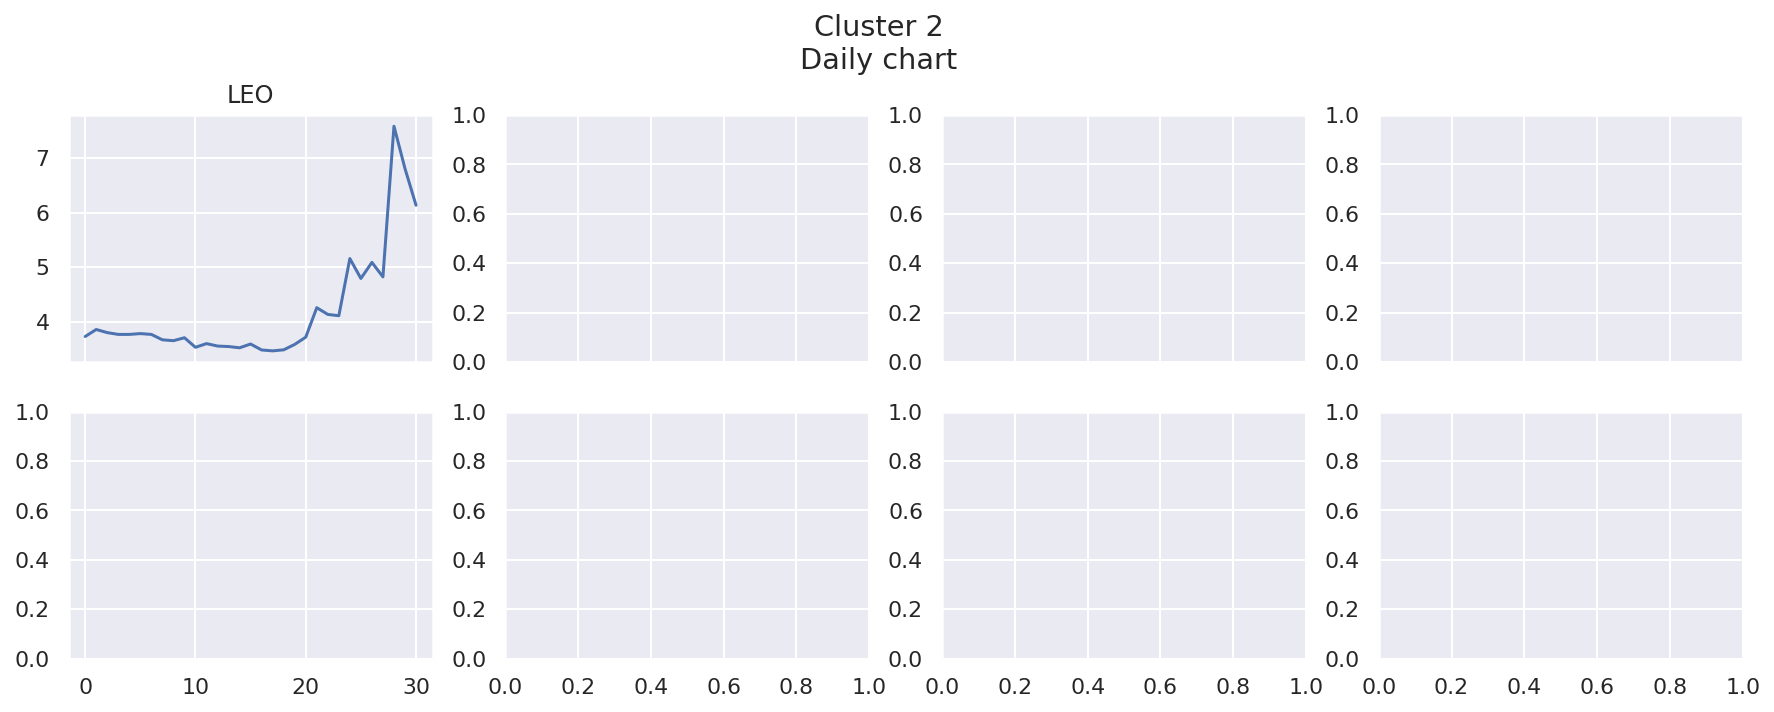

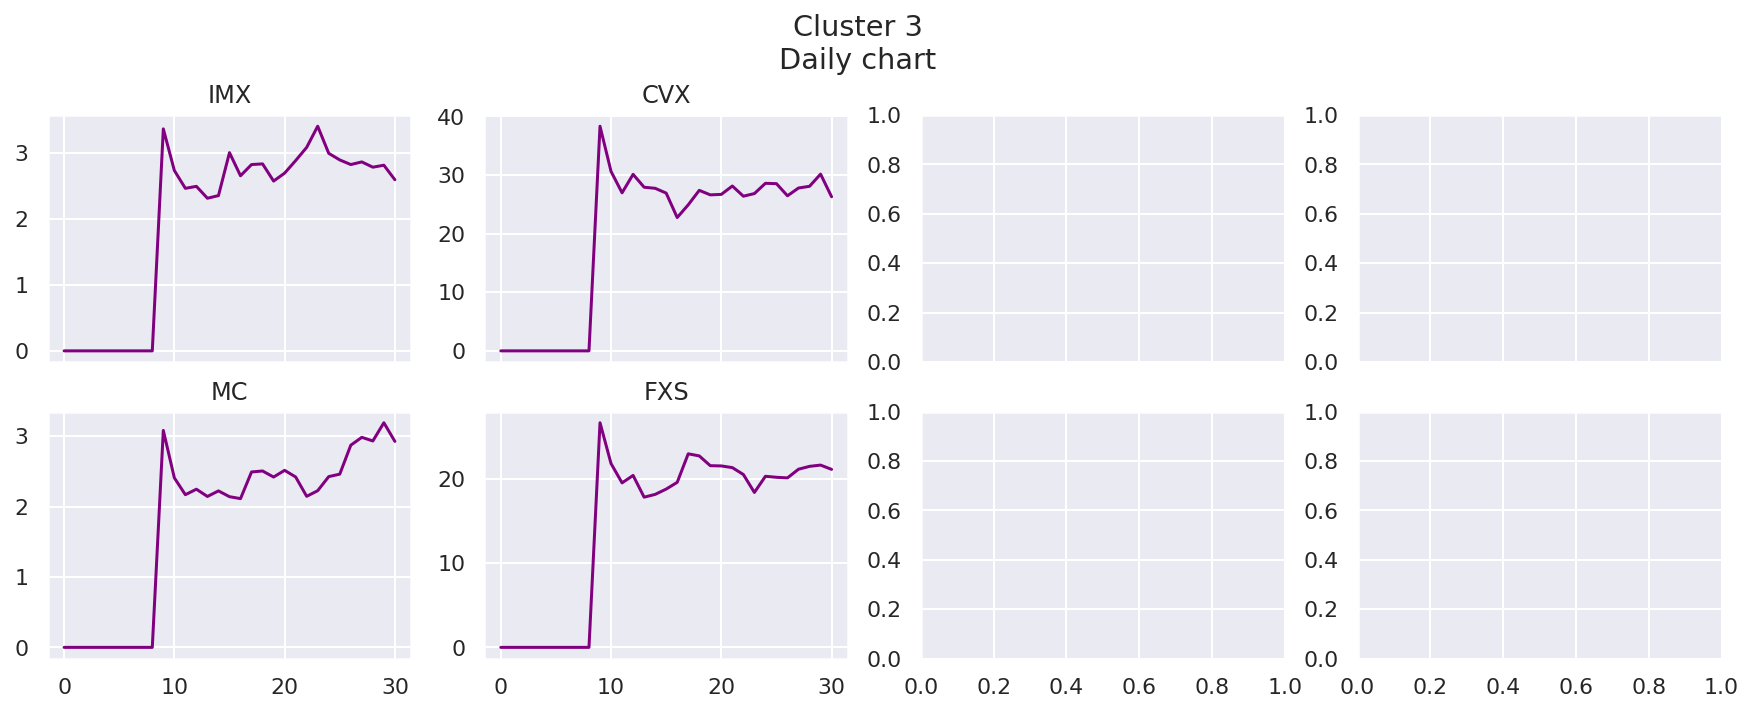

In [18]:
clustering_study(data_day, metric="dtw", title="Daily chart")

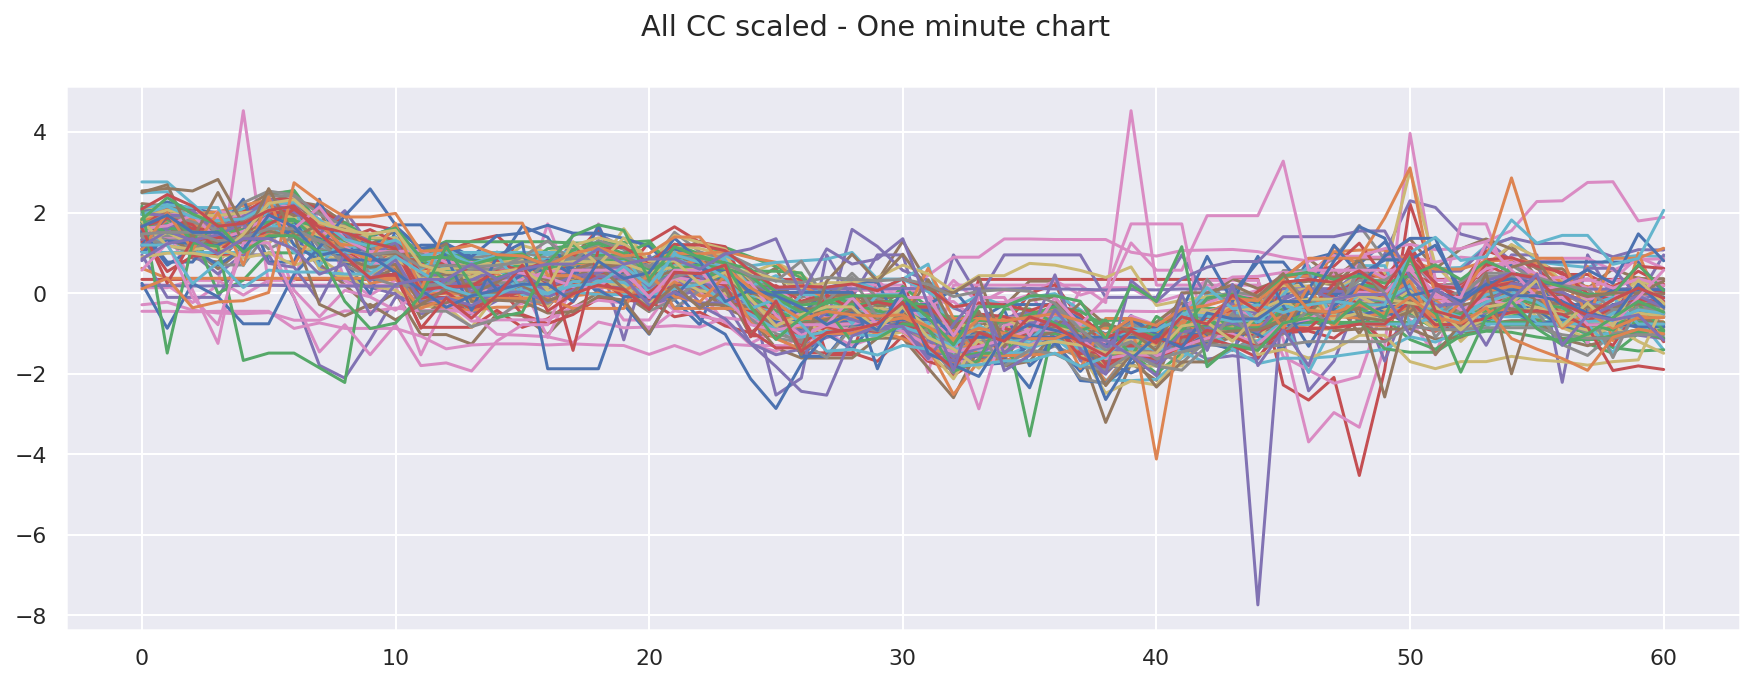

  0%|          | 0/8 [00:00<?, ?it/s]

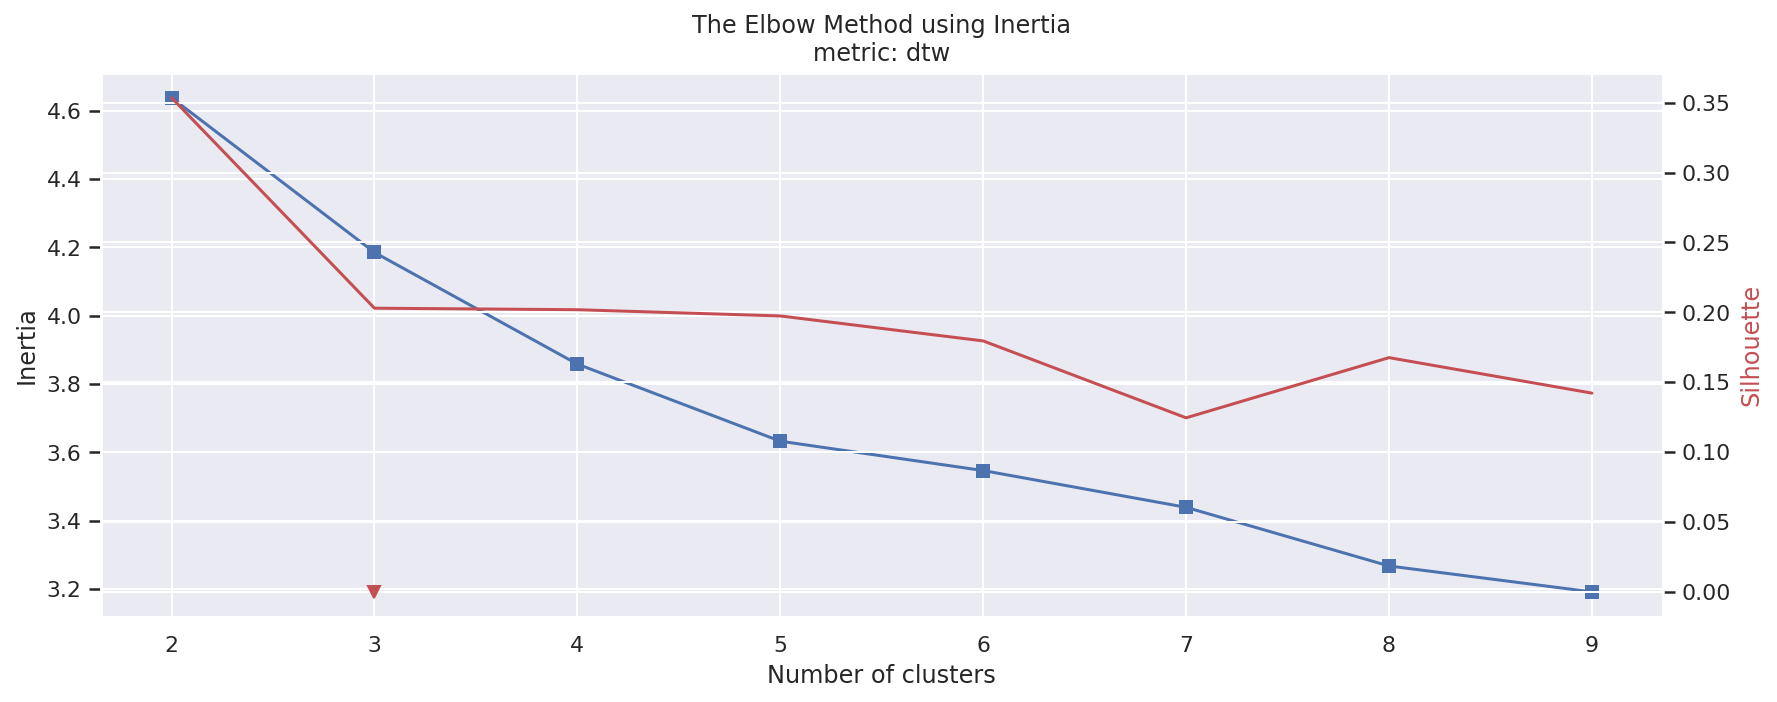

Optimal number of clusters: None


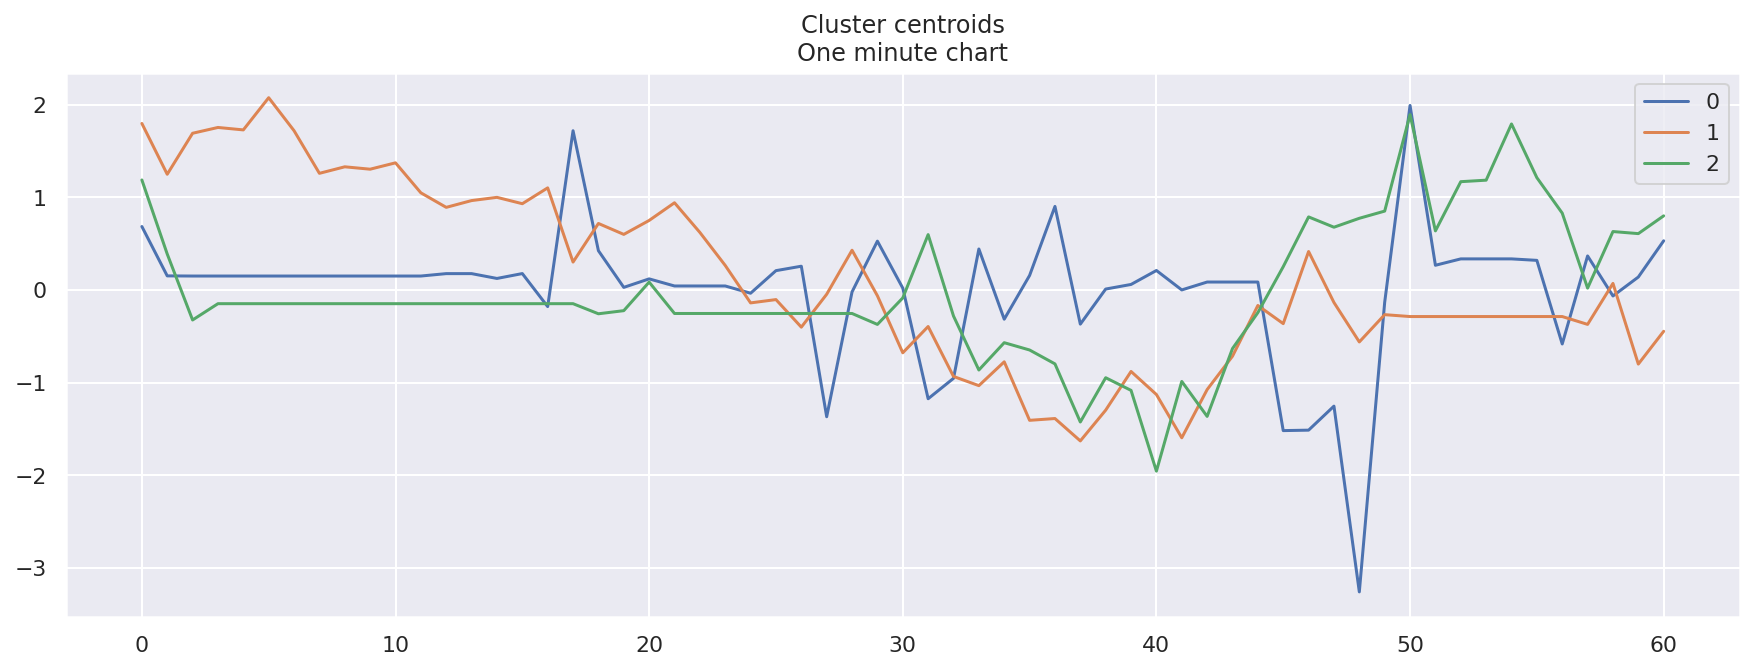

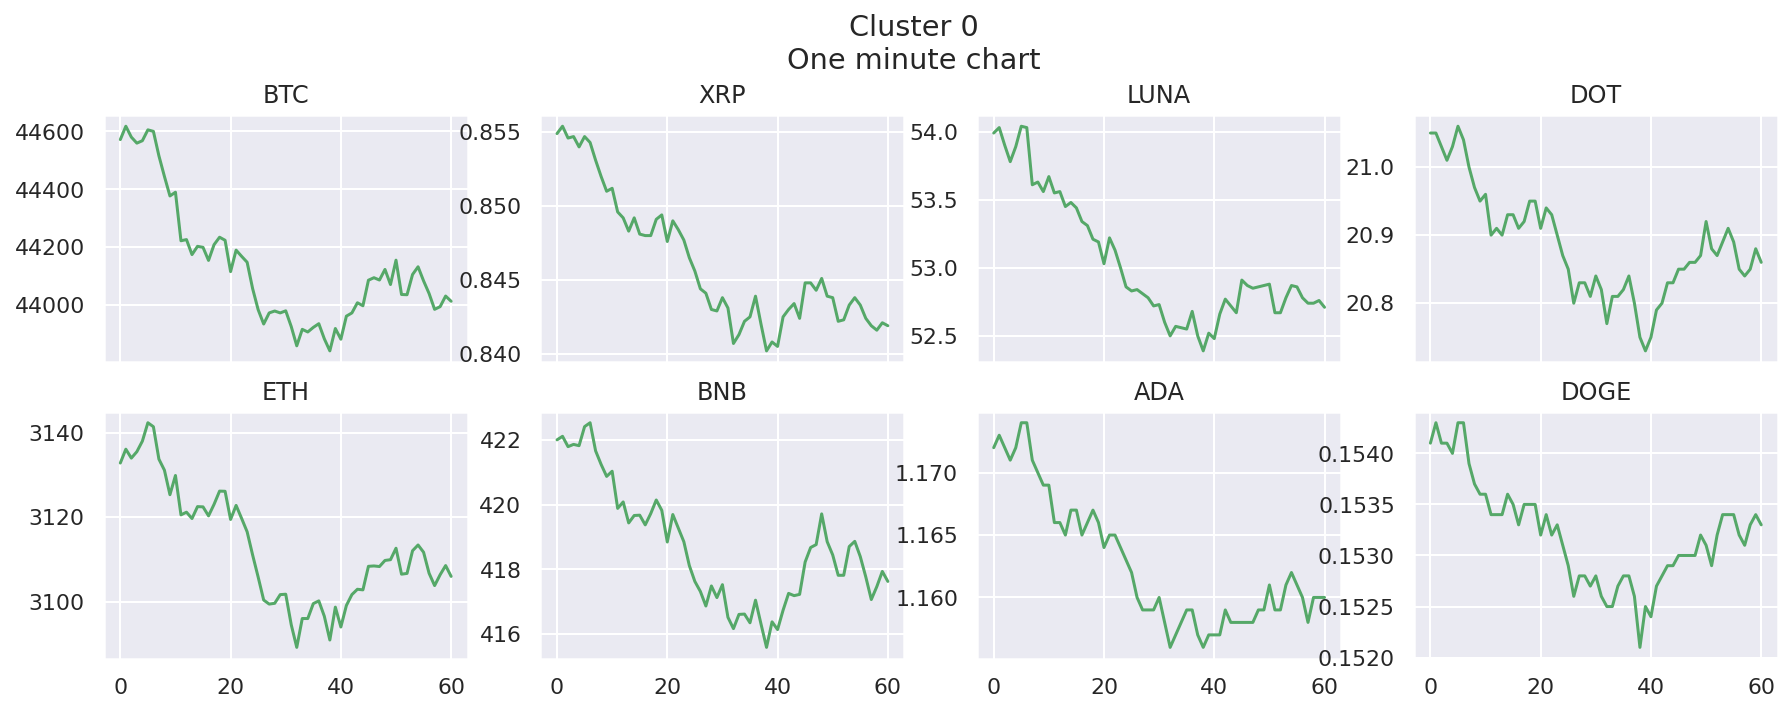

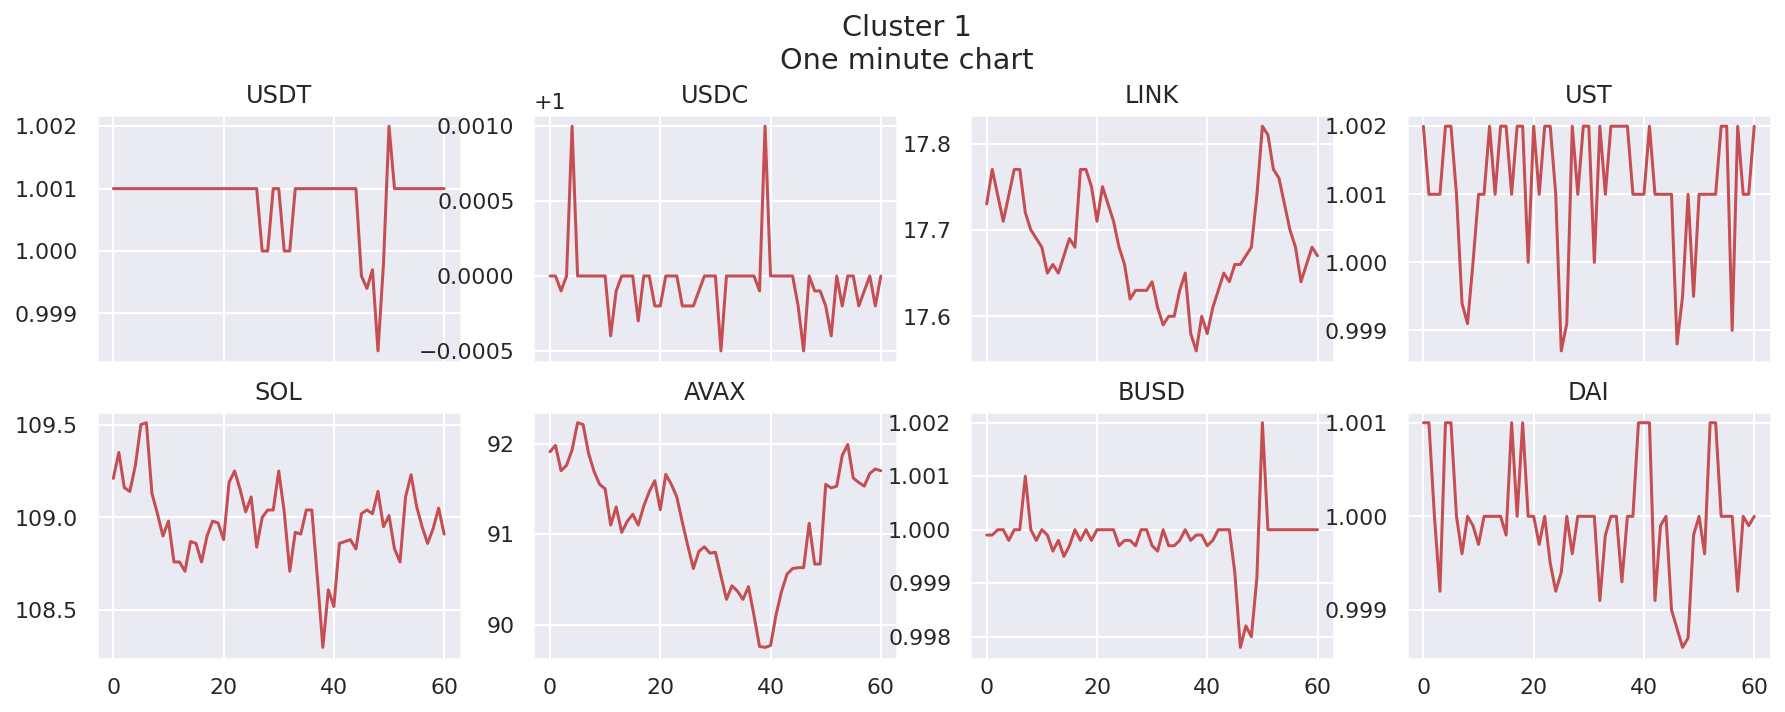

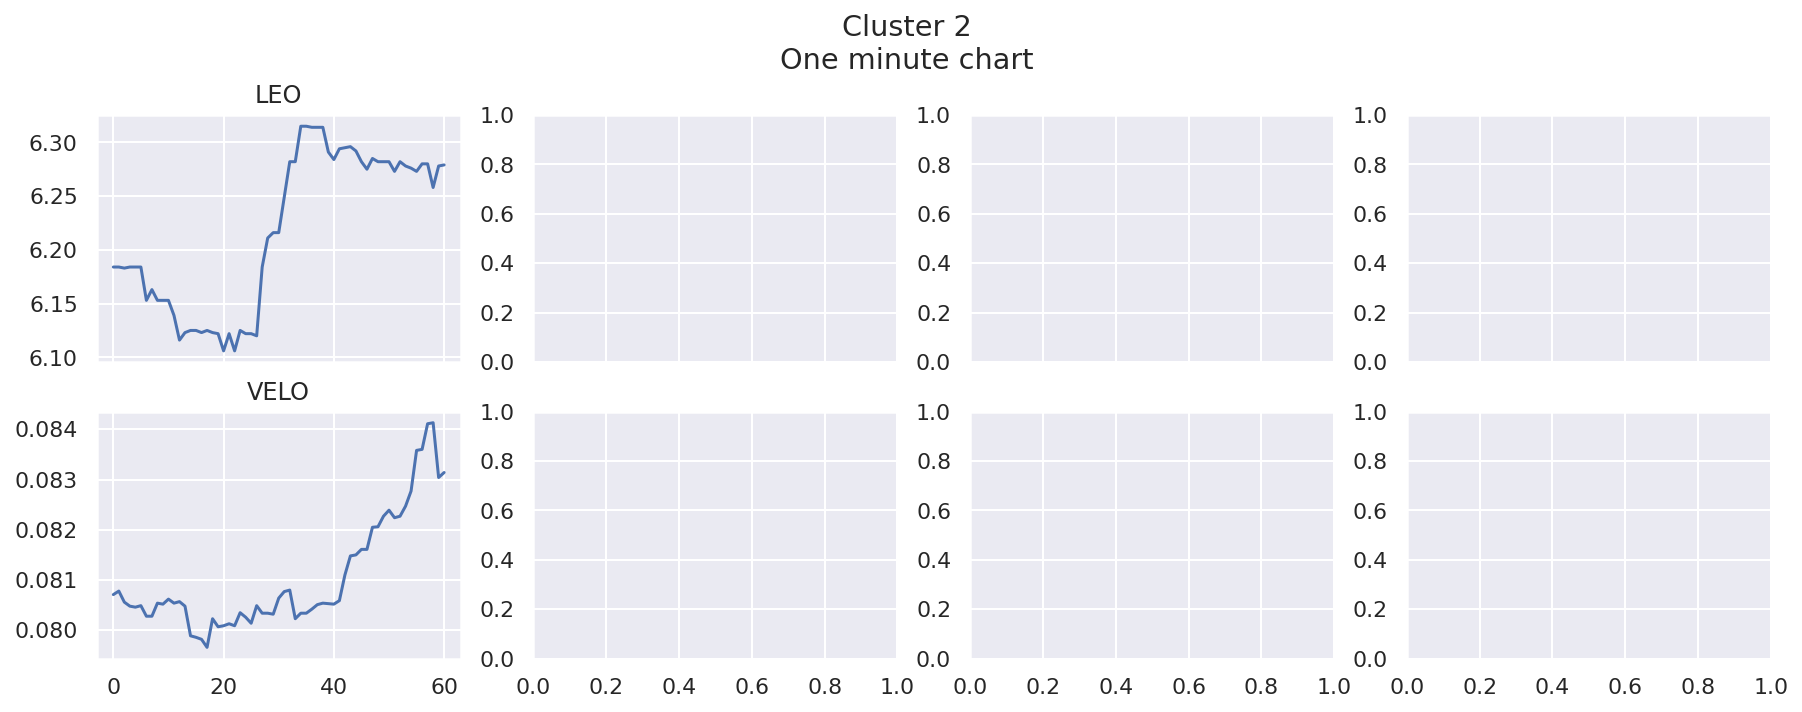

In [19]:
clustering_study(data_minute, metric="dtw", title="One minute chart")

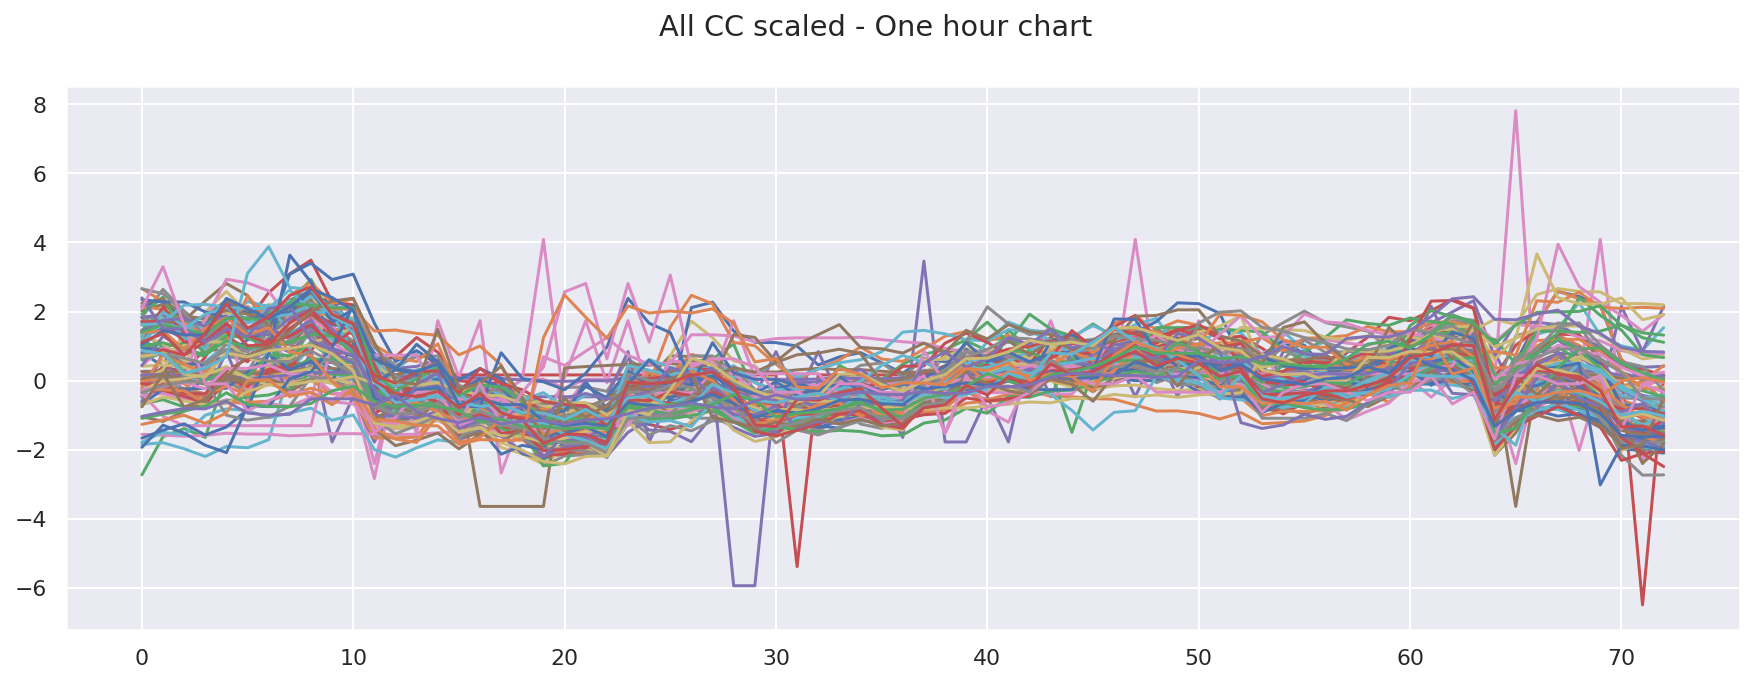

  0%|          | 0/8 [00:00<?, ?it/s]

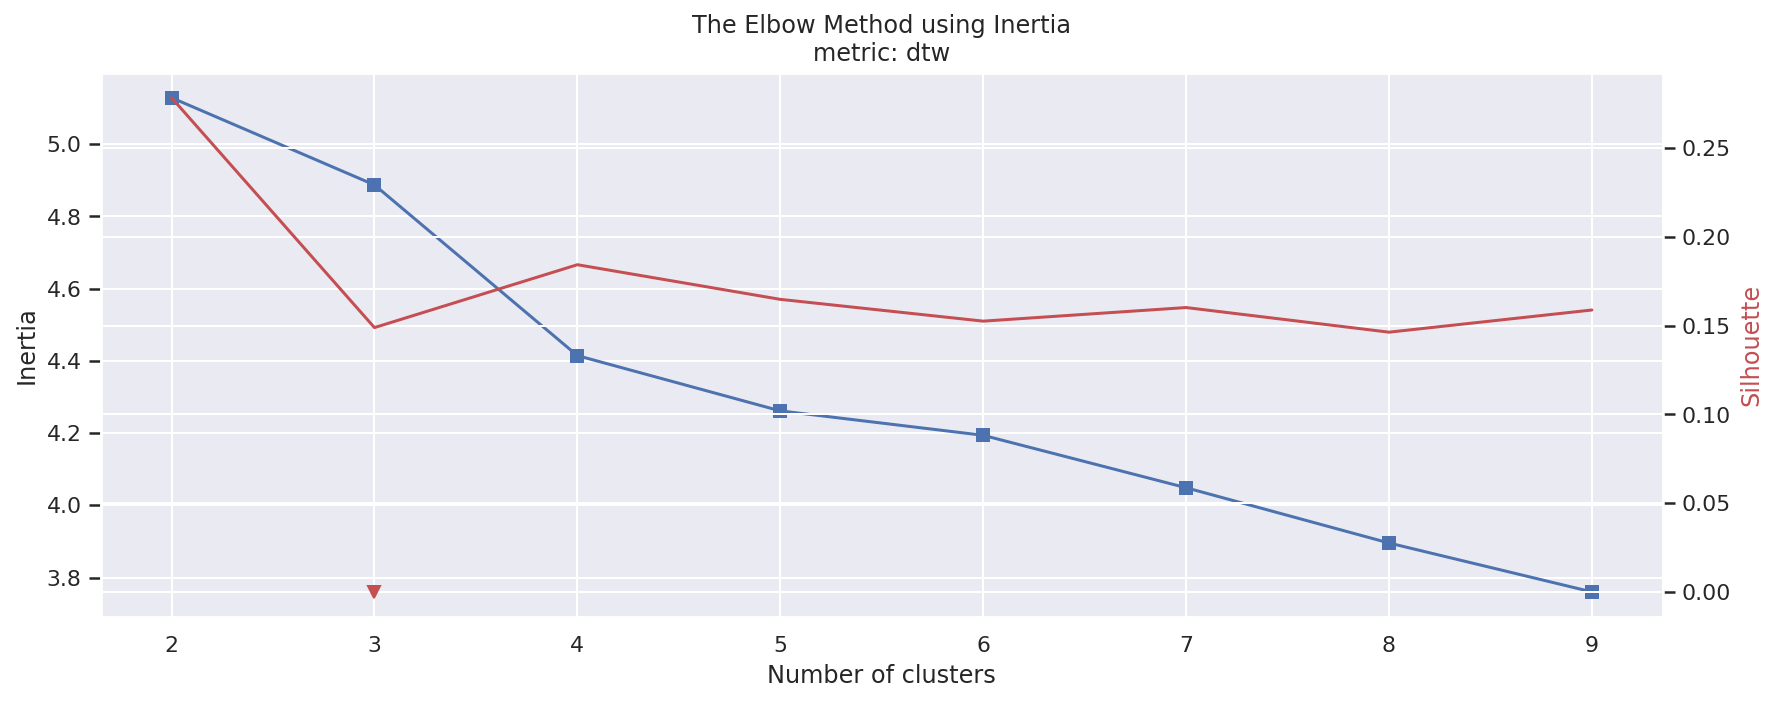

Optimal number of clusters: None


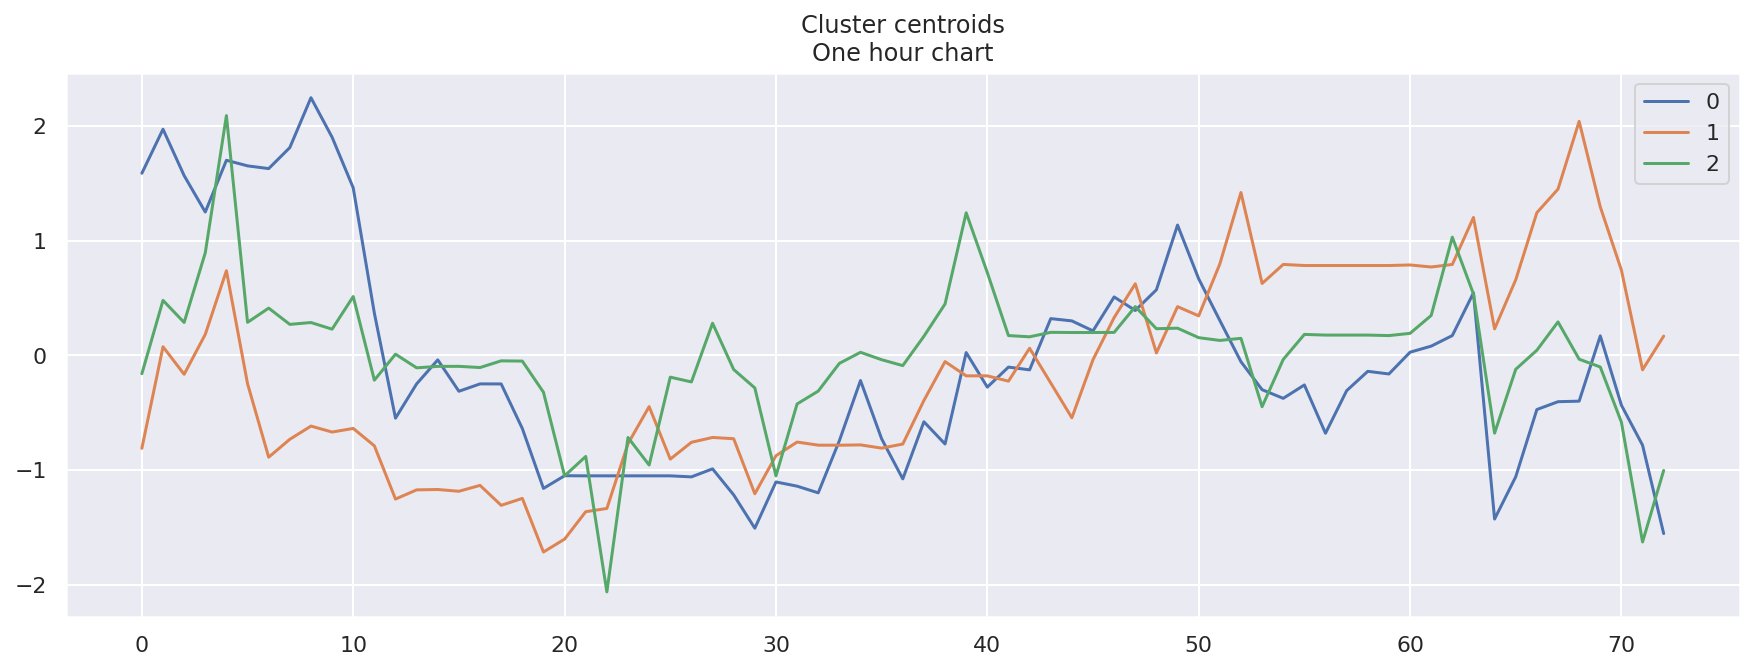

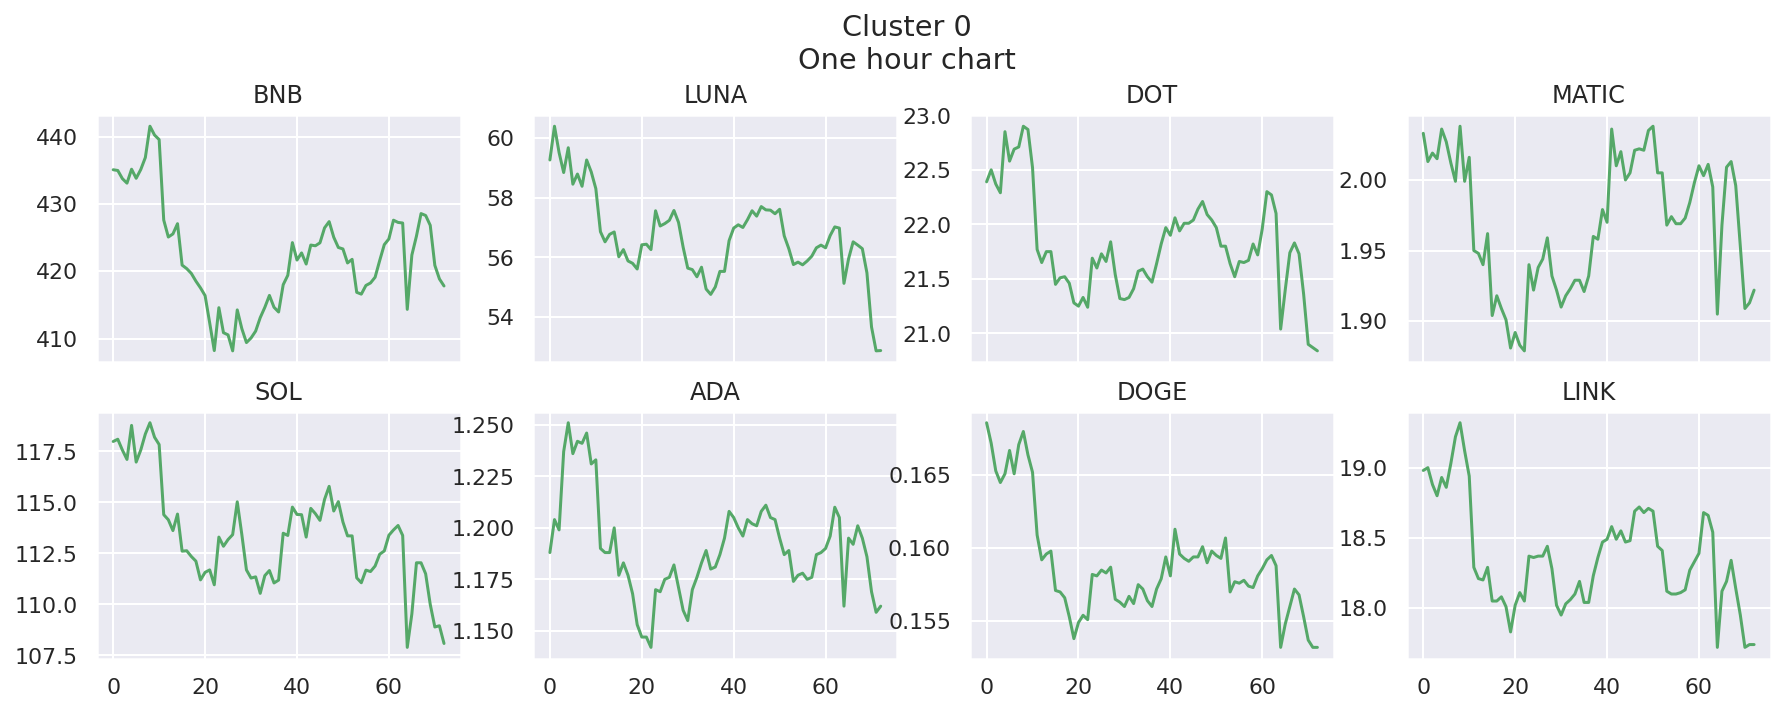

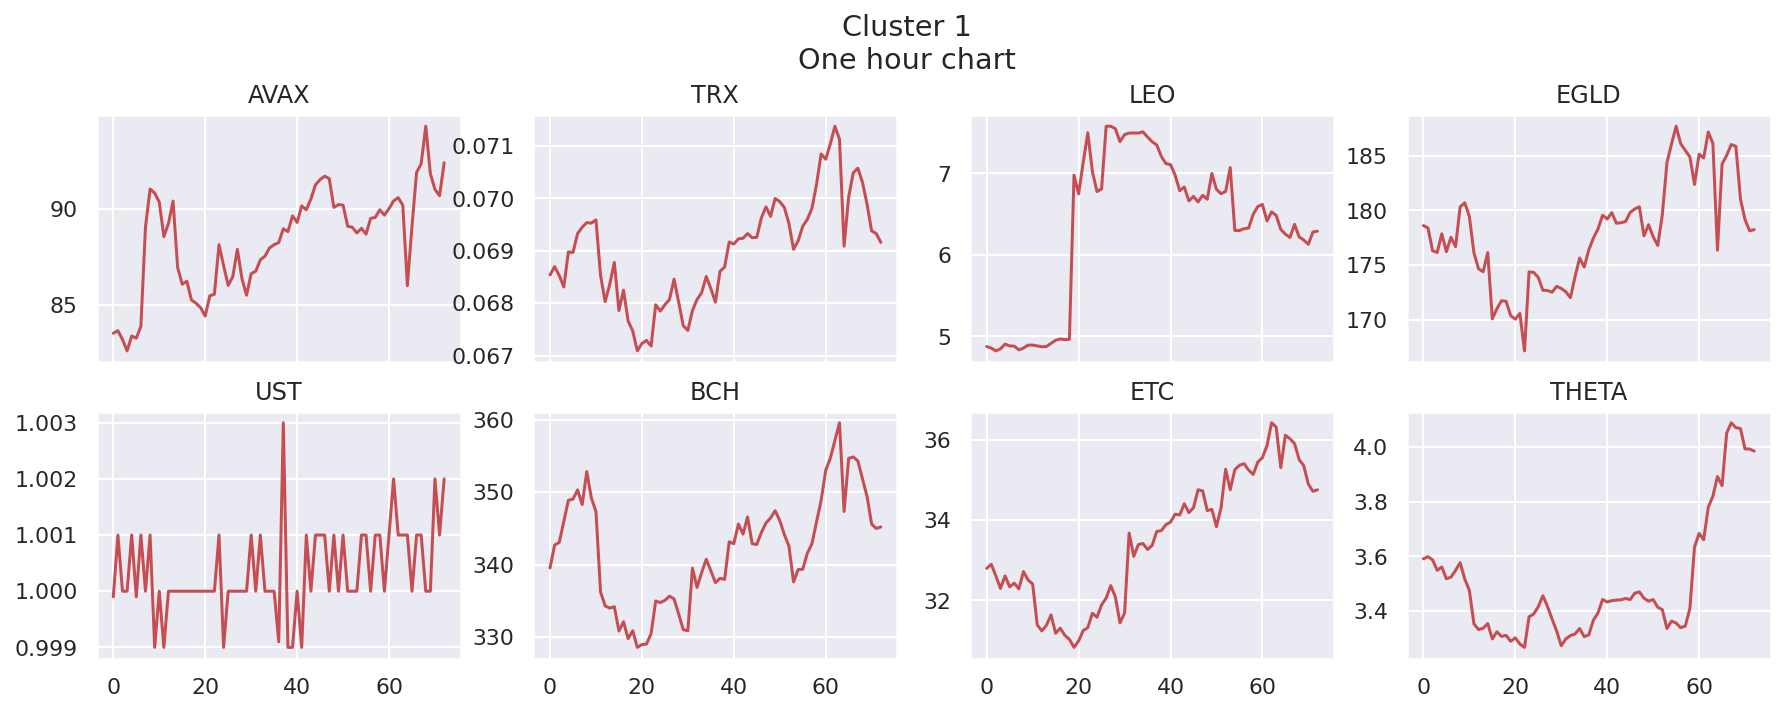

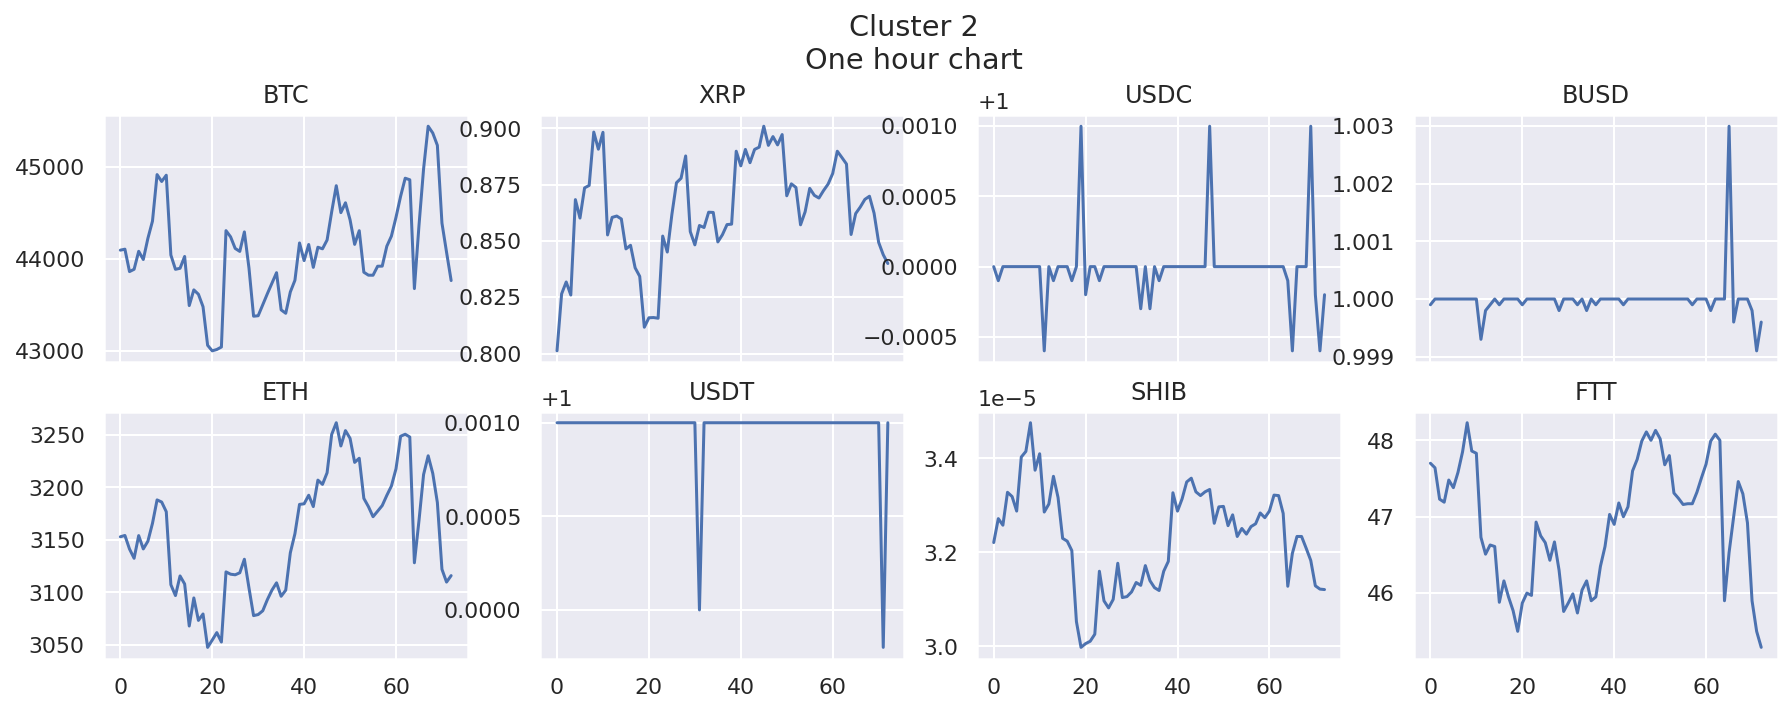

In [20]:
clustering_study(data_hour, metric="dtw", title="One hour chart")

###  Clustering analysis with TSFEL

#### Choose domain features

In [21]:
# Uncomment the line with a chosen domain

cfg_file = tsfel.get_features_by_domain()  # All features will be extracted.
# cgf_file = tsfel.get_features_by_domain("statistical")  # All statistical domain features will be extracted
# cfg_file = tsfel.get_features_by_domain("temporal")     # All temporal domain features will be extracted
# cgf_file = tsfel.get_features_by_domain("spectral")     # All spectral domain features will be extracted

In [22]:
data_day.head()

BTC      ETH     XRP   USDT     BNB     SOL    USDC   LUNA    ADA  \
0  42743.03  3240.32  0.7703  1.001  463.38  140.25  1.0000  73.51  1.188   
1  43919.67  3373.03  0.7989  1.000  487.51  151.51  1.0000  81.91  1.312   
2  42575.61  3242.26  0.7678  1.000  475.57  146.20  1.0000  78.36  1.233   
3  43089.83  3309.66  0.7734  1.001  490.36  146.18  1.0000  81.45  1.293   
4  43088.74  3328.63  0.7796  1.000  494.66  147.74  0.9996  87.30  1.292   

    AVAX  ...  FXS      HT     CHZ    ENJ   JASMY    ENS    XCH    DFI  \
0  89.64  ...  0.0   9.403  0.2641  2.317  0.0708  26.75  88.52  2.618   
1  96.02  ...  0.0   9.509  0.2775  2.521  0.0730  27.99  95.48  2.994   
2  89.76  ...  0.0   9.511  0.2637  2.374  0.0695  25.69  92.94  2.971   
3  90.40  ...  0.0   9.855  0.2668  2.411  0.0707  26.28  91.61  3.001   
4  93.08  ...  0.0  10.020  0.2669  2.452  0.0703  26.68  92.12  3.102   

      BSV    ANC  
0  110.19  2.592  
1  112.83  2.704  
2  109.33  2.600  
3  113.02  2.503  
4  112.63  2.506  

[5 rows x 95 columns]

In [23]:
# Get list of features names
x_temp = tsfel.time_series_features_extractor(cfg_file, data_day["BTC"], window_size=30)
tf_columns = x_temp.columns
xtf = pd.DataFrame(columns=data_day.columns, index=tf_columns)
# Fill df with features
for col in xtf.columns:
    xtf[col] = tsfel.time_series_features_extractor(
        cfg_file, data_day[col], window_size=30
    ).T
xtf.dropna(inplace=True)
Xt = pd.DataFrame(scaler.fit_transform(xtf), columns=data_day.columns, index=xtf.index)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [24]:
Xt.head()

BTC     ETH     XRP    USDT     BNB     SOL  \
0_Absolute energy          3.1888  3.1886  0.8308  0.1331  3.1889  3.1883   
0_Area under the curve    -0.1214 -0.1217 -0.0092  0.0266 -0.1211 -0.1208   
0_Autocorrelation          3.1888  3.1886  0.8308  0.1331  3.1889  3.1883   
0_Centroid                -0.1214 -0.1217 -0.0126  0.0261 -0.1212 -0.1210   
0_ECDF Percentile Count_0 -0.1214 -0.1217  0.3269  0.0291 -0.1212 -0.1210   

                             USDC    LUNA     ADA    AVAX  ...     FXS  \
0_Absolute energy          0.1208  3.1878  1.3241  3.1884  ...  3.1571   
0_Area under the curve     0.0363 -0.1193  0.0054 -0.1195  ... -0.1156   
0_Autocorrelation          0.1208  3.1878  1.3241  3.1884  ...  3.1571   
0_Centroid                 0.0359 -0.1198 -0.0011 -0.1199  ... -0.1170   
0_ECDF Percentile Count_0  0.0383 -0.1196  0.1841 -0.1198  ... -0.1150   

                               HT     CHZ     ENJ   JASMY     ENS     XCH  \
0_Absolute energy          3.1221  0.0899  2.0993 -0.0584  3.1751  3.1890   
0_Area under the curve    -0.1002 -0.0230 -0.0211 -0.0635 -0.1127 -0.1190   
0_Autocorrelation          3.1221  0.0899  2.0993 -0.0584  3.1751  3.1890   
0_Centroid                -0.1034 -0.0175 -0.0289 -0.0571 -0.1142 -0.1194   
0_ECDF Percentile Count_0 -0.0963  0.4617  0.0760  0.3464 -0.1128 -0.1193   

                              DFI     BSV     ANC  
0_Absolute energy          2.5588  3.1890  1.9872  
0_Area under the curve    -0.0477 -0.1196 -0.0254  
0_Autocorrelation          2.5588  3.1890  1.9872  
0_Centroid                -0.0550 -0.1199 -0.0333  
0_ECDF Percentile Count_0  0.0089 -0.1198  0.0774  

[5 rows x 95 columns]

#### Distribution of distances in time features dataset

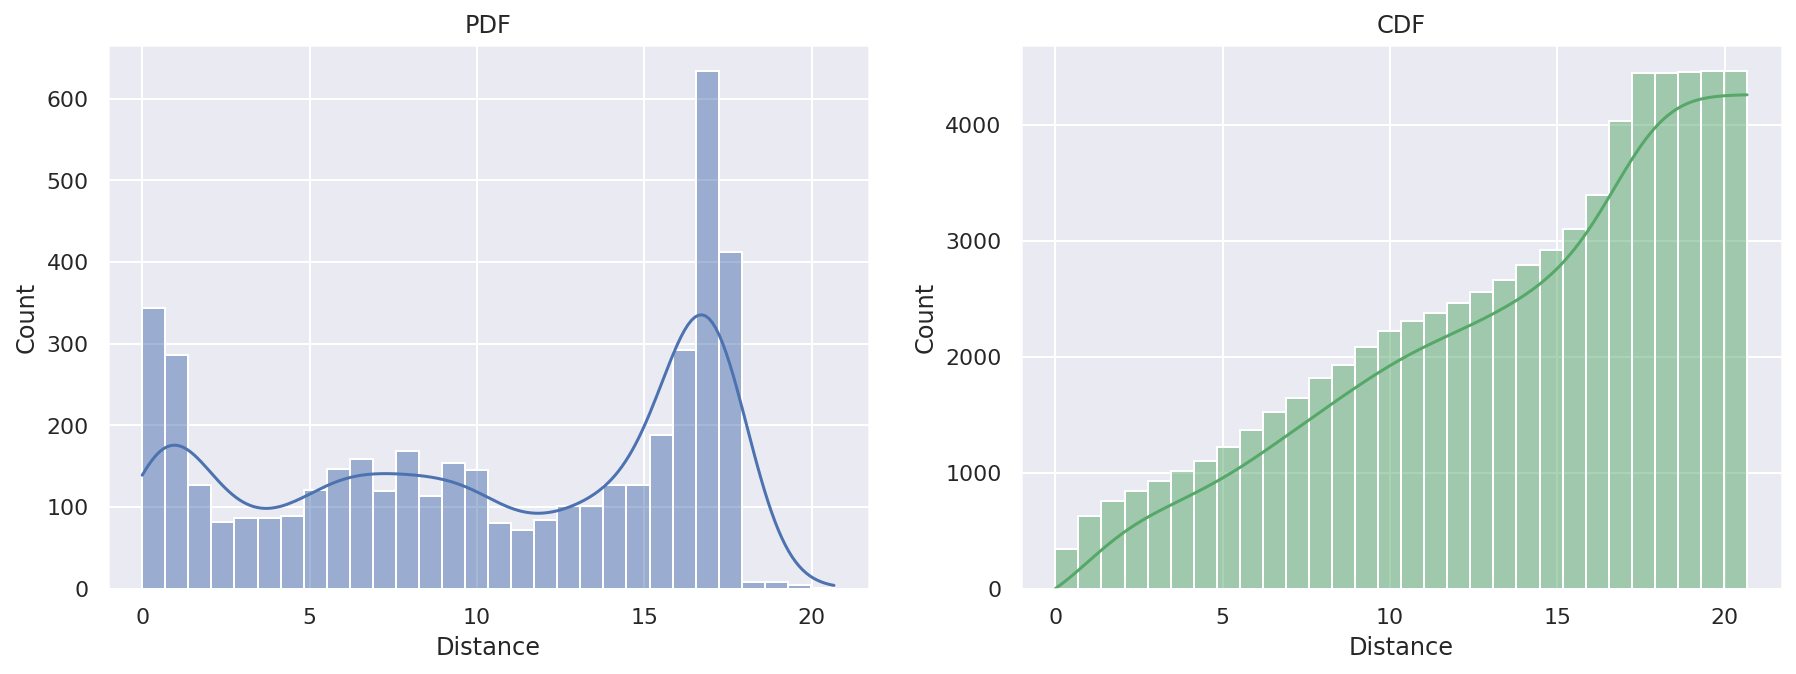

In [25]:
distances_distr_plot(Xt)

  0%|          | 0/8 [00:00<?, ?it/s]

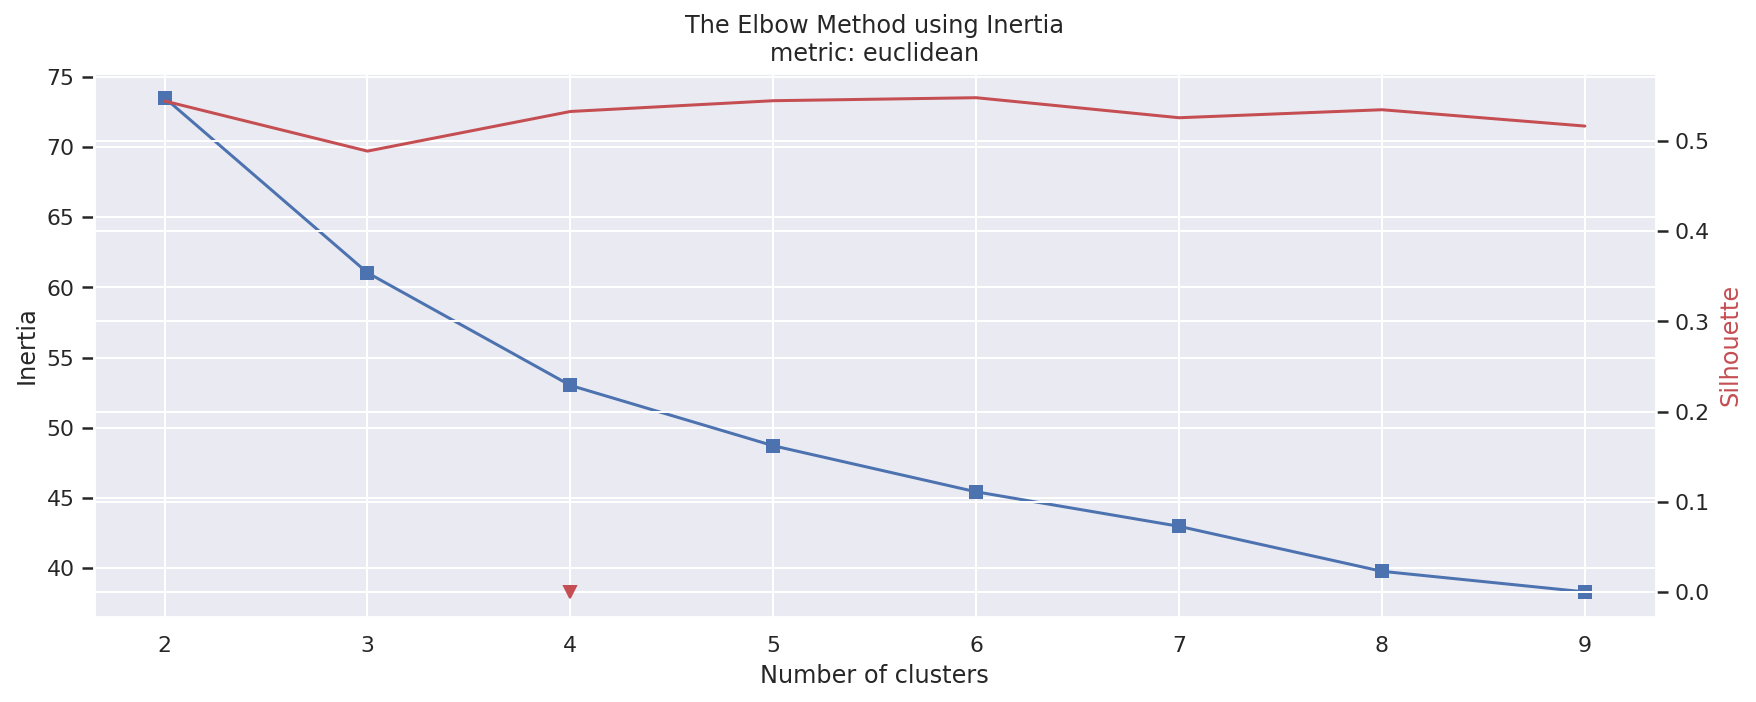

Optimal number of clusters: 4


In [26]:
n_clusters = elbow_study(Xt.T, metric="euclidean", model=KMeans)

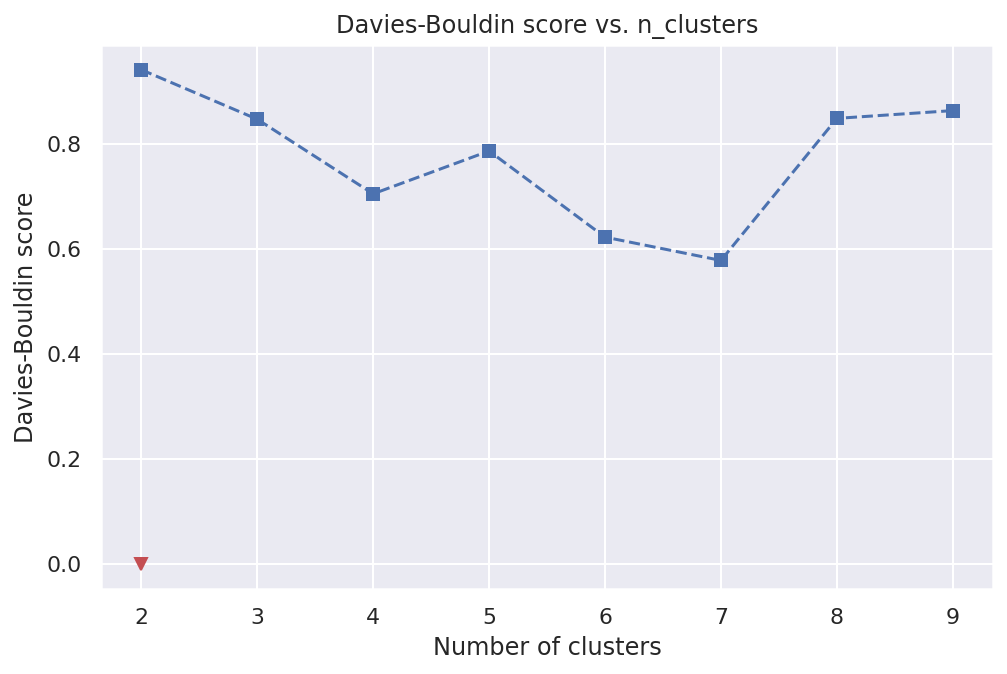

Optimal number of clusters: 2


In [27]:
n_clusters = davies_bouldin_plot(Xt)

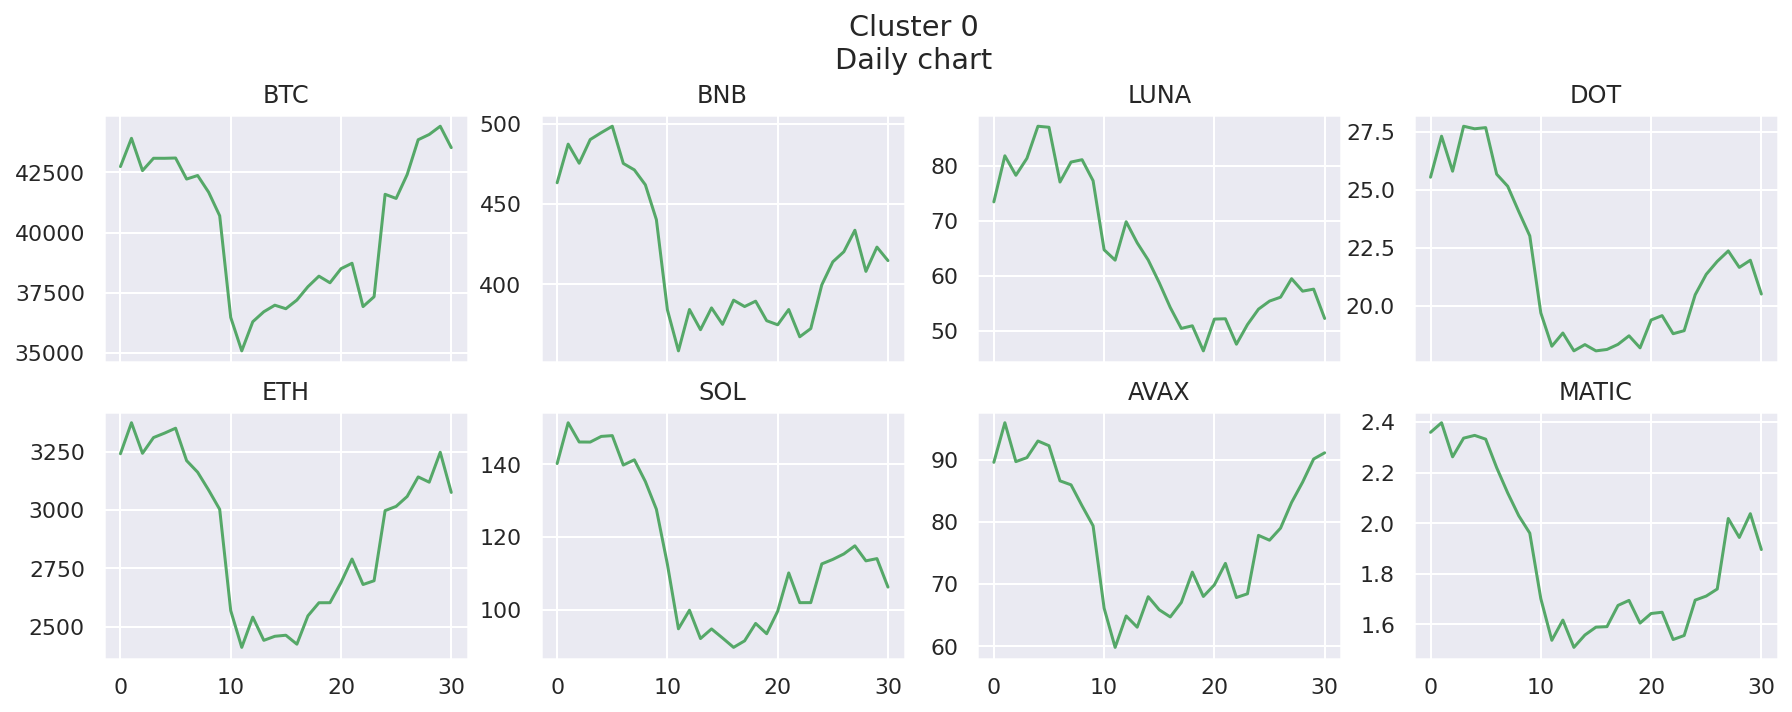

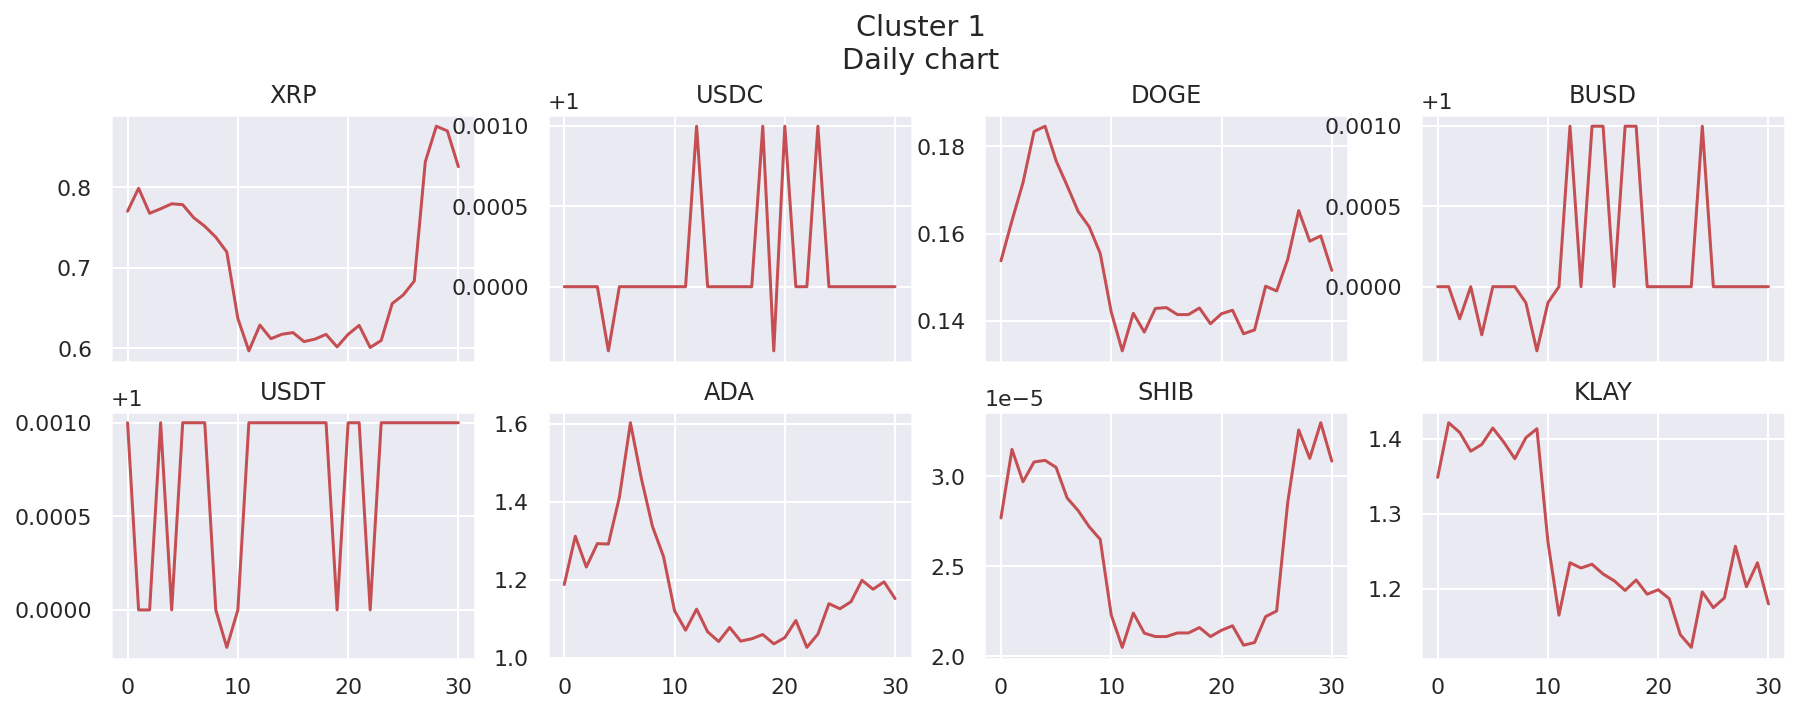

In [28]:
plot_clusters_2(
    data_day,
    Xt=Xt,
    n_clusters=n_clusters,
    random_state=random_state,
    title="Daily chart",
)

### Compare models results

### Conclusion